In [80]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, 
                            roc_auc_score, roc_curve, precision_recall_curve,
                            f1_score, accuracy_score)
import statsmodels
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import json
from pathlib import Path
import re

In [81]:
# =============================================================================
# LOAD ALL SUBJECTS' DATA
# =============================================================================
# Update these paths to your data directories
preprocessed_dir = Path('/Users/pranmodu/Projects/columbia/liinc/data/results/preprocessing')
raw_dir = Path('/Users/pranmodu/Projects/columbia/liinc/data/json')

# Get all preprocessed JSON files
preprocessed_files = list(preprocessed_dir.glob('preprocessing_*.json'))
print(f"Found {len(preprocessed_files)} preprocessed files")

# =============================================================================
# CHOOSE BASELINE METHOD
# =============================================================================
baseline_method = 't3_stable_pre_decision'  # or 't0_initial_fixation', 't1_post_stabilization', 't2_early_post_stimulus'

Found 10 preprocessed files


In [82]:
# =============================================================================
# EXTRACT FEATURES FOR ALL SUBJECTS
# =============================================================================
all_physiology_features = []
all_behavior_features = []
all_outcomes = []
all_subject_ids = []
all_trial_ids = []

for preprocessed_file in preprocessed_files:
    
    # Load preprocessed data
    with open(preprocessed_file, 'r') as f:
        preprocessed = json.load(f)
    
    subject_id = preprocessed['subject_id']
    print(f"\nProcessing subject: {subject_id}")
    
    # Find corresponding raw data file
    matches = list(raw_dir.glob(f"*{subject_id.split('_')[-1]}.json"))
    pattern = subject_id.replace("_", ".*")  # makes regex flexible for possible text in between
    match = next((f for f in matches if re.search(pattern, f.name)), None)
    if not match:
        print("No matching file found.")
        continue
    
    with open(match, 'r') as f:
        raw_data = json.load(f)
    
    subject_trial_count = 0
    
    for trial_id, trial_data in preprocessed['trial_data'].items():

        # Get the baseline-corrected pupil data for chosen method
        method_data = trial_data['methods'][baseline_method]
        
        if method_data['success'] != True:
            continue
        
        # Get raw trial data for behavioral features
        raw_trial = raw_data['trials'][int(trial_id)-1]
        
        # Skip trials that weren't submitted
        if not raw_trial['gamble details']['submitted']:
            continue
        
        # =============================================================================
        # PHYSIOLOGY FEATURES (PRE + POST SUBMIT)
        # =============================================================================

        # Split data into pre-submit and post-submit periods
        time_aligned = np.array(trial_data['time_relative_to_submit'])
        pupil_avg = np.array(method_data['pupil_avg_baselined'])
        pupil_L = np.array(method_data['pupil_L_baselined'])
        pupil_R = np.array(method_data['pupil_R_baselined'])

        # Remove NaN values
        valid_mask = ~np.isnan(pupil_avg)
        pupil_avg_clean = pupil_avg[valid_mask]
        pupil_L_clean = pupil_L[valid_mask]
        pupil_R_clean = pupil_R[valid_mask]
        time_clean = time_aligned[valid_mask]

        if len(pupil_avg_clean) < 20:
            continue

        # ============= PRE-SUBMIT DATA (for prediction) =============
        pre_submit_mask = time_clean <= 0
        pupil_pre = pupil_avg_clean[pre_submit_mask]
        pupil_L_pre = pupil_L_clean[pre_submit_mask]
        pupil_R_pre = pupil_R_clean[pre_submit_mask]
        time_pre = time_clean[pre_submit_mask]

        # Check minimum samples for pre-submit
        if len(pupil_pre) < 10:
            continue

        # Calculate derivatives for pre-submit
        pupil_velocity_pre = np.diff(pupil_pre) if len(pupil_pre) > 1 else np.array([0])
        pupil_acceleration_pre = np.diff(pupil_velocity_pre) if len(pupil_velocity_pre) > 1 else np.array([0])
        dilation_mask_pre = pupil_velocity_pre > 0 if len(pupil_velocity_pre) > 0 else np.array([False])

        # ============= POST-SUBMIT DATA (for outcome response) =============
        post_submit_mask = (time_clean > 0) & (time_clean <= 2.0)
        pupil_post = pupil_avg_clean[post_submit_mask]
        pupil_L_post = pupil_L_clean[post_submit_mask]
        pupil_R_post = pupil_R_clean[post_submit_mask]
        time_post = time_clean[post_submit_mask]

        # Calculate derivatives for post-submit (if enough samples)
        if len(pupil_post) > 1:
            pupil_velocity_post = np.diff(pupil_post)
            pupil_acceleration_post = np.diff(pupil_velocity_post) if len(pupil_velocity_post) > 1 else np.array([0])
            dilation_mask_post = pupil_velocity_post > 0 if len(pupil_velocity_post) > 0 else np.array([False])
        else:
            pupil_velocity_post = np.array([0])
            pupil_acceleration_post = np.array([0])
            dilation_mask_post = np.array([False])

        # =============================================================================
        # EXTRACT FEATURES FOR BOTH PERIODS
        # =============================================================================

        physiology_features = {
            # ==================== PRE-SUBMIT FEATURES ====================
            # Central tendency
            'pupil_mean_pre': np.mean(pupil_pre),
            'pupil_std_pre': np.std(pupil_pre),
            
            # Temporal dynamics
            'pupil_slope_pre': np.polyfit(time_pre, pupil_pre, 1)[0] if len(time_pre) > 1 else 0,
            'time_to_peak_pre': time_pre[np.argmax(pupil_pre)] - time_pre[0] if len(time_pre) > 0 else 0,
            
            # Change from start to end
            'pupil_change_pre': (np.mean(pupil_pre[-min(10, len(pupil_pre)):]) - 
                                np.mean(pupil_pre[:min(10, len(pupil_pre))])) if len(pupil_pre) >= 10 else 0,
            
            # Variability
            'pupil_cv_pre': np.std(pupil_pre) / np.abs(np.mean(pupil_pre)) if (len(pupil_pre) > 0 and np.mean(pupil_pre) != 0) else 0,
            
            # Velocity metrics
            'pupil_velocity_mean_pre': np.mean(np.abs(pupil_velocity_pre)) if len(pupil_velocity_pre) > 0 else 0,
            'pupil_max_dilation_rate_pre': np.max(pupil_velocity_pre) if len(pupil_velocity_pre) > 0 else 0,
            'pupil_max_constriction_rate_pre': np.abs(np.min(pupil_velocity_pre)) if len(pupil_velocity_pre) > 0 else 0,
            
            # Acceleration
            'pupil_acceleration_std_pre': np.std(pupil_acceleration_pre) if len(pupil_acceleration_pre) > 1 else 0,
            
            # Temporal patterns
            'pct_time_dilating_pre': np.mean(dilation_mask_pre) if len(dilation_mask_pre) > 0 else 0,
            'num_dilation_peaks_pre': np.sum(np.diff(np.sign(pupil_velocity_pre)) > 0) if len(pupil_velocity_pre) > 1 else 0,
            
            # Eye asymmetry
            'eye_asymmetry_pre': np.nanmean(np.abs(pupil_L_pre - pupil_R_pre)) if len(pupil_L_pre) > 0 else 0,
            'eye_asymmetry_std_pre': np.nanstd(pupil_L_pre - pupil_R_pre) if len(pupil_L_pre) > 1 else 0,
            
            # ==================== POST-SUBMIT FEATURES ====================
            # Central tendency
            'pupil_mean_post': np.mean(pupil_post) if len(pupil_post) > 0 else 0,
            'pupil_std_post': np.std(pupil_post) if len(pupil_post) > 1 else 0,
            
            # Temporal dynamics
            'pupil_slope_post': np.polyfit(time_post, pupil_post, 1)[0] if len(time_post) > 1 else 0,
            'time_to_peak_post': time_post[np.argmax(pupil_post)] - time_post[0] if len(time_post) > 0 else 0,
            
            # Variability
            'pupil_cv_post': np.std(pupil_post) / np.abs(np.mean(pupil_post)) if (len(pupil_post) > 0 and np.mean(pupil_post) != 0) else 0,
            
            # Velocity metrics
            'pupil_velocity_mean_post': np.mean(np.abs(pupil_velocity_post)) if len(pupil_velocity_post) > 0 else 0,
            'pupil_max_dilation_rate_post': np.max(pupil_velocity_post) if len(pupil_velocity_post) > 0 else 0,
            'pupil_max_constriction_rate_post': np.abs(np.min(pupil_velocity_post)) if len(pupil_velocity_post) > 0 else 0,
            
            # Temporal patterns
            'pct_time_dilating_post': np.mean(dilation_mask_post) if len(dilation_mask_post) > 0 else 0,
            'num_dilation_peaks_post': np.sum(np.diff(np.sign(pupil_velocity_post)) > 0) if len(pupil_velocity_post) > 1 else 0,
            
            # Eye asymmetry
            'eye_asymmetry_post': np.nanmean(np.abs(pupil_L_post - pupil_R_post)) if len(pupil_L_post) > 0 else 0,
            'eye_asymmetry_std_post': np.nanstd(pupil_L_post - pupil_R_post) if len(pupil_L_post) > 1 else 0,
            
            # ==================== TRANSITION FEATURES ====================
            # Compare pre vs post
            'pupil_mean_change_pre_to_post': (np.mean(pupil_post) - np.mean(pupil_pre)) if len(pupil_post) > 0 and len(pupil_pre) > 0 else 0,
            'pupil_slope_change_pre_to_post': ((np.polyfit(time_post, pupil_post, 1)[0] if len(time_post) > 1 else 0) - 
                                            (np.polyfit(time_pre, pupil_pre, 1)[0] if len(time_pre) > 1 else 0)),
            
            # ==================== BASELINE ====================
            'baseline_L': method_data['baseline_L'],
            'baseline_R': method_data['baseline_R'],
            'baseline_avg': (method_data['baseline_L'] + method_data['baseline_R']) / 2,
        }
        
        # =============================================================================
        # BEHAVIOR FEATURES (from raw trial data)
        # =============================================================================
        gamble_params = raw_trial['gamble details']['gamble parameters']
        lct = raw_trial['lct']
        
        # Extract timing information
        show_screen_time = None
        submit_time = None
        click_time = None
        
        for event in lct:
            if 'show screen' in event['event']:
                show_screen_time = event['time']
            elif 'gamble clicked' in event['event']:
                click_time = event['time']
            elif 'submit' in event['event']:
                submit_time = event['time']
        
        if show_screen_time is None or submit_time is None:
            continue
        
        # Calculate timing metrics (convert to seconds)
        reaction_time = (click_time - show_screen_time) / 1000 if click_time else np.nan
        decision_time = (submit_time - show_screen_time) / 1000

        # Calculate expected values
        invest_ev = (gamble_params['invest amount 1'] * gamble_params['invest probability 1'] + 
                    gamble_params['invest amount 2'] * gamble_params['invest probability 2'])
        keep_ev = gamble_params['keep amount']
        ev_difference = invest_ev - keep_ev

        # Calculate variance
        invest_variance = ((gamble_params['invest amount 1'] - invest_ev)**2 * gamble_params['invest probability 1'] +
                        (gamble_params['invest amount 2'] - invest_ev)**2 * gamble_params['invest probability 2'])
        
        # Choice information
        final_choice = raw_trial['gamble details']['choices'][-1]['choice'] if len(raw_trial['gamble details']['choices']) > 0 else None
        chose_invest = 1 if final_choice == 'INVEST' else 0
        
        behavior_features = {
            # TIMING - Independent information
            'reaction_time': reaction_time if not np.isnan(reaction_time) else decision_time,
            'decision_time': decision_time,
            
            # GAMBLE PARAMETERS 
            'ev_difference': ev_difference,  # Captures relative attractiveness
            
            # RISK - Independent from EV
            'invest_variance': invest_variance,  # OR use std: np.sqrt(invest_variance)
            
            # AMBIGUITY - Independent
            'ambiguity': gamble_params['ambiguity'],
            
            # CONDITION - Independent  
            'condition_social': 1 if gamble_params['condition'] == 'social' else 0,
            
            # NORMALIZED RISK METRIC - Independent combination
            'risk_premium': ev_difference / np.sqrt(invest_variance) if invest_variance > 0 else 0,
        }
                
        # =============================================================================
        # OUTCOME VARIABLE
        # =============================================================================
        outcome = chose_invest  # Predicting INVEST (1) vs KEEP (0)
        
        # Store everything
        all_physiology_features.append(physiology_features)
        all_behavior_features.append(behavior_features)
        all_outcomes.append(outcome)
        all_subject_ids.append(subject_id)
        all_trial_ids.append(f"{trial_id}_{subject_id}")
        
        subject_trial_count += 1
    
    print(f"  Extracted {subject_trial_count} valid trials")

# =============================================================================
# CREATE DATAFRAMES
# =============================================================================
physiology_df = pd.DataFrame(all_physiology_features)
physiology_df.insert(0, 'subject_id', all_subject_ids)
physiology_df.insert(1, 'trial_id', all_trial_ids)

behavior_df = pd.DataFrame(all_behavior_features)
behavior_df.insert(0, 'subject_id', all_subject_ids)
behavior_df.insert(1, 'trial_id', all_trial_ids)

outcomes = np.array(all_outcomes)
subjects = np.array(all_subject_ids)

print(f"\n{'='*80}")
print(f"DATA SUMMARY (ALL SUBJECTS)")
print(f"{'='*80}")
print(f"Total subjects: {len(np.unique(subjects))}")
print(f"Total valid trials: {len(outcomes)}")
print(f"Physiology features: {physiology_df.shape[1]}")
print(f"Behavior features: {behavior_df.shape[1]}")
print(f"\nOutcome distribution:")
print(f"  KEEP (0): {np.sum(outcomes == 0)} ({np.mean(outcomes == 0):.1%})")
print(f"  INVEST (1): {np.sum(outcomes == 1)} ({np.mean(outcomes == 1):.1%})")

# Per-subject breakdown
print(f"\nPer-subject trial counts:")
subject_counts = pd.DataFrame({'subject': subjects, 'outcome': outcomes})
print(subject_counts.groupby('subject')['outcome'].agg(['count', 'mean']))

# Check for missing values
print(f"\nMissing values in physiology features:")
missing_physio = physiology_df.isnull().sum()
if missing_physio.sum() > 0:
    print(missing_physio[missing_physio > 0])
else:
    print("None!")

print(f"\nMissing values in behavior features:")
missing_behavior = behavior_df.isnull().sum()
if missing_behavior.sum() > 0:
    print(missing_behavior[missing_behavior > 0])
else:
    print("None!")


Processing subject: 0928_1600_U9TEJGM
  Extracted 93 valid trials

Processing subject: 0930_1700_U9TEJGM
  Extracted 123 valid trials

Processing subject: 1005_1600_U9TEJGM
  Extracted 51 valid trials

Processing subject: 0930_1700_539136F
  Extracted 95 valid trials

Processing subject: 0928_1600_539136F
  Extracted 110 valid trials

Processing subject: 1005_1600_539136F
  Extracted 121 valid trials

Processing subject: 0928_1600_9M4VCHG
  Extracted 117 valid trials

Processing subject: 0930_1700_9M4VCHG
  Extracted 112 valid trials

Processing subject: 0927_0930_U9TEJGM
  Extracted 99 valid trials

Processing subject: 1005_1600_9M4VCHG
  Extracted 123 valid trials

DATA SUMMARY (ALL SUBJECTS)
Total subjects: 10
Total valid trials: 1044
Physiology features: 33
Behavior features: 9

Outcome distribution:
  KEEP (0): 356 (34.1%)
  INVEST (1): 688 (65.9%)

Per-subject trial counts:
                   count      mean
subject                           
0927_0930_U9TEJGM     99  0.373737
0

In [83]:
pre_cols = [col for col in physiology_df.columns if '_pre' in col or 'baseline' in col]
print(pre_cols)
post_cols = [col for col in physiology_df.columns if '_post' in col or 'baseline' in col]
print(post_cols)

['pupil_mean_pre', 'pupil_std_pre', 'pupil_slope_pre', 'time_to_peak_pre', 'pupil_change_pre', 'pupil_cv_pre', 'pupil_velocity_mean_pre', 'pupil_max_dilation_rate_pre', 'pupil_max_constriction_rate_pre', 'pupil_acceleration_std_pre', 'pct_time_dilating_pre', 'num_dilation_peaks_pre', 'eye_asymmetry_pre', 'eye_asymmetry_std_pre', 'pupil_mean_change_pre_to_post', 'pupil_slope_change_pre_to_post', 'baseline_L', 'baseline_R', 'baseline_avg']
['pupil_mean_post', 'pupil_std_post', 'pupil_slope_post', 'time_to_peak_post', 'pupil_cv_post', 'pupil_velocity_mean_post', 'pupil_max_dilation_rate_post', 'pupil_max_constriction_rate_post', 'pct_time_dilating_post', 'num_dilation_peaks_post', 'eye_asymmetry_post', 'eye_asymmetry_std_post', 'pupil_mean_change_pre_to_post', 'pupil_slope_change_pre_to_post', 'baseline_L', 'baseline_R', 'baseline_avg']


In [84]:
physiology_df

,subject_id,trial_id,pupil_mean_pre,pupil_std_pre,pupil_slope_pre,time_to_peak_pre,pupil_change_pre,pupil_cv_pre,pupil_velocity_mean_pre,pupil_max_dilation_rate_pre,...,pupil_max_constriction_rate_post,pct_time_dilating_post,num_dilation_peaks_post,eye_asymmetry_post,eye_asymmetry_std_post,pupil_mean_change_pre_to_post,pupil_slope_change_pre_to_post,baseline_L,baseline_R,baseline_avg
0,0928_1600_U9TEJGM,4_0928_1600_U9TEJGM,0.025747,0.600433,-0.887872,0.249962,-1.162754,23.320559,0.047701,0.159757,...,0.041880,0.571429,4,1.947865,0.799251,0.024053,1.727285,0.385186,-0.646653,-0.130734
1,0928_1600_U9TEJGM,9_0928_1600_U9TEJGM,0.447229,0.273984,-0.071215,1.199820,0.140531,0.612625,0.037372,0.132774,...,0.085567,0.512605,6,0.840462,0.961168,0.105395,0.735737,-0.401363,-0.434381,-0.417872
2,0928_1600_U9TEJGM,10_0928_1600_U9TEJGM,-0.133402,0.235444,-0.154442,0.283291,0.164866,1.764922,0.029469,0.105264,...,0.082252,0.546218,5,2.797592,0.772804,0.094350,0.511445,0.852446,-0.949945,-0.048750
3,0928_1600_U9TEJGM,13_0928_1600_U9TEJGM,0.112158,0.420877,-0.459861,0.000000,-1.264087,3.752537,0.041500,0.093582,...,0.099197,0.705882,5,0.728148,0.594755,0.681989,1.330580,-1.065998,-0.272744,-0.669371
4,0928_1600_U9TEJGM,14_0928_1600_U9TEJGM,0.473647,0.163630,0.021084,0.316619,-0.064944,0.345468,0.023148,0.078801,...,0.488948,0.588235,6,0.714150,0.869629,-0.104471,-0.081926,-0.761234,-0.474944,-0.618089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,1005_1600_9M4VCHG,127_1005_1600_9M4VCHG,0.020989,0.085878,-0.073127,0.699983,0.064608,4.091614,0.009521,0.025306,...,0.028283,0.554622,4,0.130786,0.114521,0.361748,0.548191,-0.301158,-0.163690,-0.232424
1040,1005_1600_9M4VCHG,128_1005_1600_9M4VCHG,0.202468,0.364592,-0.595604,0.349991,-0.782873,1.800738,0.016513,0.038453,...,0.051750,0.781513,2,0.105787,0.160191,-0.062029,0.793070,-0.272404,-0.363283,-0.317844
1041,1005_1600_9M4VCHG,129_1005_1600_9M4VCHG,0.054047,0.290519,-0.402281,0.149996,-0.881716,5.375273,0.016987,0.023292,...,0.045766,0.655462,3,0.225155,0.121863,-0.080505,0.568160,-0.303054,-0.112461,-0.207758
1042,1005_1600_9M4VCHG,130_1005_1600_9M4VCHG,0.206058,0.390699,-0.577294,0.316659,-0.928542,1.896065,0.015856,0.026724,...,0.011397,0.605042,4,0.437918,1.252414,0.030301,1.053241,-0.282334,-0.341956,-0.312145


In [85]:
behavior_df

,subject_id,trial_id,reaction_time,decision_time,ev_difference,invest_variance,ambiguity,condition_social,risk_premium
0,0928_1600_U9TEJGM,4_0928_1600_U9TEJGM,0.003120,0.003809,-0.059,77.938419,0,0,-0.006683
1,0928_1600_U9TEJGM,9_0928_1600_U9TEJGM,0.002609,0.003631,0.827,14.735571,6,0,0.215438
2,0928_1600_U9TEJGM,10_0928_1600_U9TEJGM,0.003532,0.004365,0.586,32.854404,3,1,0.102235
3,0928_1600_U9TEJGM,13_0928_1600_U9TEJGM,0.002743,0.004208,0.172,57.335616,6,0,0.022715
4,0928_1600_U9TEJGM,14_0928_1600_U9TEJGM,0.001410,0.002254,0.669,25.313739,0,0,0.132968
...,...,...,...,...,...,...,...,...,...
1039,1005_1600_9M4VCHG,127_1005_1600_9M4VCHG,0.000877,0.001632,0.728,20.054016,3,0,0.162566
1040,1005_1600_9M4VCHG,128_1005_1600_9M4VCHG,0.002654,0.003543,0.178,67.289716,6,1,0.021699
1041,1005_1600_9M4VCHG,129_1005_1600_9M4VCHG,0.000899,0.001755,0.829,10.503459,0,0,0.255793
1042,1005_1600_9M4VCHG,130_1005_1600_9M4VCHG,0.001088,0.002166,0.812,7.011456,0,1,0.306656


In [86]:
physiology_df_pre = physiology_df[['subject_id', 'trial_id'] + pre_cols]
physiology_df_post = physiology_df[['subject_id', 'trial_id'] + post_cols]  

In [87]:
from sklearn.impute import SimpleImputer

print(f"Before imputation: {physiology_df.isnull().sum().sum()} NaN values")

physiology_df_numerical = physiology_df.drop(columns=['subject_id', 'trial_id'])
columns = list(physiology_df_numerical.columns)

imputer = SimpleImputer(strategy='median')
physiology_df_numerical = pd.DataFrame(
    imputer.fit_transform(physiology_df_numerical),
    columns=columns,
    index=physiology_df_numerical.index
)

print(f"After imputation: {physiology_df_numerical.isnull().sum().sum()} NaN values")

Before imputation: 0 NaN values
After imputation: 0 NaN values



MULTICOLLINEARITY ANALYSIS - PHYSIOLOGY FEATURES

⚠️  Highly correlated feature pairs (|r| > 0.9):
None


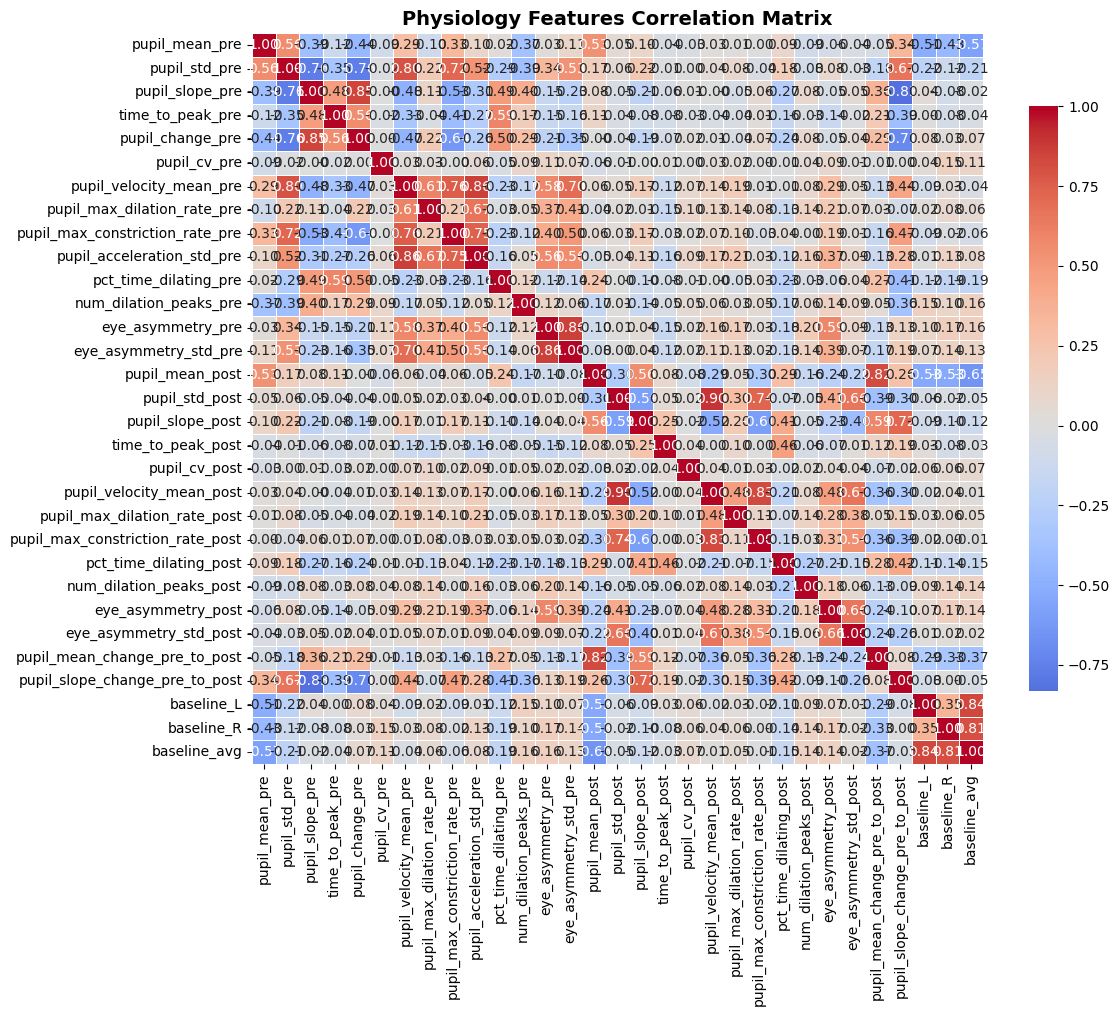

In [88]:
# =============================================================================
# CHECK MULTICOLLINEARITY IN PHYSIOLOGY FEATURES
# =============================================================================
print(f"\n{'='*80}")
print(f"MULTICOLLINEARITY ANALYSIS - PHYSIOLOGY FEATURES")
print(f"{'='*80}")

# Calculate correlation matrix
physiology_corr = physiology_df_numerical.corr()

# Find highly correlated pairs (>0.9)
high_corr_pairs = []
for i in range(len(physiology_corr.columns)):
    for j in range(i+1, len(physiology_corr.columns)):
        if abs(physiology_corr.iloc[i, j]) > 0.9:
            high_corr_pairs.append({
                'feature_1': physiology_corr.columns[i],
                'feature_2': physiology_corr.columns[j],
                'correlation': physiology_corr.iloc[i, j]
            })

print(f"\n⚠️  Highly correlated feature pairs (|r| > 0.9):")
if len(high_corr_pairs) == 0:
    print('None')
for pair in high_corr_pairs:
    print(f"  {pair['feature_1']} <-> {pair['feature_2']}: {pair['correlation']:.3f}")

# Visualize correlation matrix
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(physiology_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
ax.set_title('Physiology Features Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# TASK 2: PHYSIOLOGY → OUTCOME (Direct)

## Random, Balanced Split

### Baseline Classification

In [89]:
# =============================================================================
# TASK 2: PHYSIOLOGY → OUTCOME (Direct)
# =============================================================================
print(f"\n{'='*80}")
print(f"TASK 2: PHYSIOLOGY → OUTCOME (Direct)")
print(f"{'='*80}")

# Prepare data
X_physio = physiology_df.drop(columns=['subject_id', 'trial_id']).values
y = outcomes

# Check class balance
print(f"\nClass balance check:")
print(f"  Minimum class size: {min(np.bincount(y))}")
print(f"  Class ratio: {np.mean(y):.3f}")

# Train-test split (stratified to maintain class balance)
X_train_physio, X_test_physio, y_train, y_test = train_test_split(
    X_physio, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTraining samples: {len(y_train)} (KEEP: {np.sum(y_train==0)}, INVEST: {np.sum(y_train==1)})")
print(f"Test samples: {len(y_test)} (KEEP: {np.sum(y_test==0)}, INVEST: {np.sum(y_test==1)})")

# Train Random Forest classifier
rf_physio = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced'
)

rf_physio.fit(X_train_physio, y_train)

# Predictions
y_pred_physio = rf_physio.predict(X_test_physio)

# Evaluation
print(f"\n{'='*80}")
print(f"CLASSIFICATION RESULTS")
print(f"{'='*80}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_physio, target_names=['KEEP', 'INVEST']))

accuracy_physio_all = accuracy_score(y_test, y_pred_physio)
f1_physio_all = f1_score(y_test, y_pred_physio, average='weighted')
print(f"\nAccuracy: {accuracy_physio_all:.3f}")
print(f"F1 Score: {f1_physio_all:.3f}")



TASK 2: PHYSIOLOGY → OUTCOME (Direct)

Class balance check:
  Minimum class size: 356
  Class ratio: 0.659

Training samples: 730 (KEEP: 249, INVEST: 481)
Test samples: 314 (KEEP: 107, INVEST: 207)

CLASSIFICATION RESULTS

Classification Report:
              precision    recall  f1-score   support

        KEEP       0.48      0.61      0.54       107
      INVEST       0.77      0.66      0.71       207

    accuracy                           0.64       314
   macro avg       0.62      0.63      0.62       314
weighted avg       0.67      0.64      0.65       314


Accuracy: 0.643
F1 Score: 0.651


### Pre predict post

In [90]:
# =============================================================================
# TASK 2: PHYSIOLOGY → OUTCOME (Direct)
# =============================================================================
print(f"\n{'='*80}")
print(f"TASK 2: PHYSIOLOGY → OUTCOME (Direct)")
print(f"{'='*80}")

# Prepare data
X_physio = physiology_df.drop(columns=['subject_id', 'trial_id'])[pre_cols].values # select pre-submit features only
y = outcomes

# Check class balance
print(f"\nClass balance check:")
print(f"  Minimum class size: {min(np.bincount(y))}")
print(f"  Class ratio: {np.mean(y):.3f}")

# Train-test split (stratified to maintain class balance)
X_train_physio, X_test_physio, y_train, y_test = train_test_split(
    X_physio, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTraining samples: {len(y_train)} (KEEP: {np.sum(y_train==0)}, INVEST: {np.sum(y_train==1)})")
print(f"Test samples: {len(y_test)} (KEEP: {np.sum(y_test==0)}, INVEST: {np.sum(y_test==1)})")

# Train Random Forest classifier
rf_physio = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced'
)

rf_physio.fit(X_train_physio, y_train)

# Predictions
y_pred_physio = rf_physio.predict(X_test_physio)

# Evaluation
print(f"\n{'='*80}")
print(f"CLASSIFICATION RESULTS (PRE FEATURES)")
print(f"{'='*80}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_physio, target_names=['KEEP', 'INVEST']))

accuracy_physio_pre = accuracy_score(y_test, y_pred_physio)
f1_physio_pre = f1_score(y_test, y_pred_physio, average='weighted')
print(f"\nAccuracy: {accuracy_physio_pre:.3f}")
print(f"F1 Score: {f1_physio_pre:.3f}")



TASK 2: PHYSIOLOGY → OUTCOME (Direct)

Class balance check:
  Minimum class size: 356
  Class ratio: 0.659

Training samples: 730 (KEEP: 249, INVEST: 481)
Test samples: 314 (KEEP: 107, INVEST: 207)

CLASSIFICATION RESULTS (PRE FEATURES)

Classification Report:
              precision    recall  f1-score   support

        KEEP       0.47      0.58      0.52       107
      INVEST       0.75      0.67      0.71       207

    accuracy                           0.64       314
   macro avg       0.61      0.62      0.61       314
weighted avg       0.66      0.64      0.64       314


Accuracy: 0.637
F1 Score: 0.644


### Post predict post

In [91]:
# =============================================================================
# TASK 2: PHYSIOLOGY → OUTCOME (Direct)
# =============================================================================
print(f"\n{'='*80}")
print(f"TASK 2: PHYSIOLOGY → OUTCOME (Direct)")
print(f"{'='*80}")

# Prepare data
X_physio = physiology_df.drop(columns=['subject_id', 'trial_id'])[post_cols].values # select post-submit features only
y = outcomes

# Check class balance
print(f"\nClass balance check:")
print(f"  Minimum class size: {min(np.bincount(y))}")
print(f"  Class ratio: {np.mean(y):.3f}")

# Train-test split (stratified to maintain class balance)
X_train_physio, X_test_physio, y_train, y_test = train_test_split(
    X_physio, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTraining samples: {len(y_train)} (KEEP: {np.sum(y_train==0)}, INVEST: {np.sum(y_train==1)})")
print(f"Test samples: {len(y_test)} (KEEP: {np.sum(y_test==0)}, INVEST: {np.sum(y_test==1)})")

# Train Random Forest classifier
rf_physio = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced'
)

rf_physio.fit(X_train_physio, y_train)

# Predictions
y_pred_physio = rf_physio.predict(X_test_physio)

# Evaluation
print(f"\n{'='*80}")
print(f"CLASSIFICATION RESULTS (POST FEATURES)")
print(f"{'='*80}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_physio, target_names=['KEEP', 'INVEST']))

accuracy_physio_post = accuracy_score(y_test, y_pred_physio)
f1_physio_post = f1_score(y_test, y_pred_physio, average='weighted')
print(f"\nAccuracy: {accuracy_physio_post:.3f}")
print(f"F1 Score: {f1_physio_post:.3f}")



TASK 2: PHYSIOLOGY → OUTCOME (Direct)

Class balance check:
  Minimum class size: 356
  Class ratio: 0.659

Training samples: 730 (KEEP: 249, INVEST: 481)
Test samples: 314 (KEEP: 107, INVEST: 207)

CLASSIFICATION RESULTS (POST FEATURES)

Classification Report:
              precision    recall  f1-score   support

        KEEP       0.48      0.64      0.55       107
      INVEST       0.77      0.65      0.71       207

    accuracy                           0.64       314
   macro avg       0.63      0.64      0.63       314
weighted avg       0.67      0.64      0.65       314


Accuracy: 0.643
F1 Score: 0.652


## LOSO

### Baseline Classification


LEAVE-ONE-SUBJECT-OUT (LOSO) CROSS-VALIDATION

Number of subjects: 10
Number of LOSO splits: 10

Fold 1/10 - Test subject: 0927_0930_U9TEJGM
  Train samples: 945 (KEEP: 294, INVEST: 651)
  Test samples: 99 (KEEP: 62, INVEST: 37)
  Accuracy: 0.586 | F1: 0.579

Fold 2/10 - Test subject: 0928_1600_539136F
  Train samples: 934 (KEEP: 274, INVEST: 660)
  Test samples: 110 (KEEP: 82, INVEST: 28)
  Accuracy: 0.300 | F1: 0.193

Fold 3/10 - Test subject: 0928_1600_9M4VCHG
  Train samples: 927 (KEEP: 311, INVEST: 616)
  Test samples: 117 (KEEP: 45, INVEST: 72)
  Accuracy: 0.581 | F1: 0.586

Fold 4/10 - Test subject: 0928_1600_U9TEJGM
  Train samples: 951 (KEEP: 337, INVEST: 614)
  Test samples: 93 (KEEP: 19, INVEST: 74)
  Accuracy: 0.376 | F1: 0.416

Fold 5/10 - Test subject: 0930_1700_539136F
  Train samples: 949 (KEEP: 356, INVEST: 593)
  Test samples: 95 (KEEP: 0, INVEST: 95)
  Accuracy: 0.958 | F1: 0.978

Fold 6/10 - Test subject: 0930_1700_9M4VCHG
  Train samples: 932 (KEEP: 314, INVEST: 6

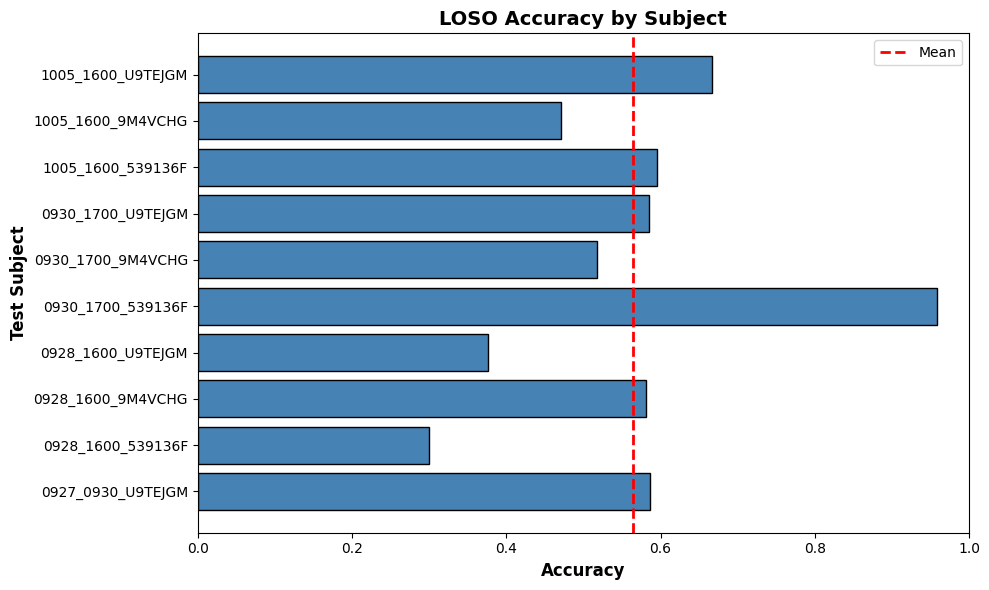

In [92]:
# =============================================================================
# LEAVE-ONE-SUBJECT-OUT (LOSO) CROSS-VALIDATION
# =============================================================================
from sklearn.model_selection import LeaveOneGroupOut

print(f"\n{'='*80}")
print(f"LEAVE-ONE-SUBJECT-OUT (LOSO) CROSS-VALIDATION")
print(f"{'='*80}")

# Prepare data
X_physio = physiology_df.drop(columns=['subject_id', 'trial_id']).values
y = outcomes
groups = subjects  # Subject IDs for grouping

# Initialize LOSO cross-validator
logo = LeaveOneGroupOut()
n_splits = logo.get_n_splits(X_physio, y, groups)

print(f"\nNumber of subjects: {len(np.unique(groups))}")
print(f"Number of LOSO splits: {n_splits}")

# Store results for each fold
loso_results = []

for fold_idx, (train_idx, test_idx) in enumerate(logo.split(X_physio, y, groups)):
    # Get train and test data
    X_train = X_physio[train_idx]
    X_test = X_physio[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]
    
    # Get the test subject ID
    test_subject = np.unique(groups[test_idx])[0]
    
    print(f"\nFold {fold_idx + 1}/{n_splits} - Test subject: {test_subject}")
    print(f"  Train samples: {len(y_train)} (KEEP: {np.sum(y_train==0)}, INVEST: {np.sum(y_train==1)})")
    print(f"  Test samples: {len(y_test)} (KEEP: {np.sum(y_test==0)}, INVEST: {np.sum(y_test==1)})")
    
    # Train model
    rf = RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced'
    )
    rf.fit(X_train, y_train)
    
    # Predictions
    y_pred = rf.predict(X_test)
    y_prob = rf.predict_proba(X_test)[:, 1]
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"  Accuracy: {accuracy:.3f} | F1: {f1:.3f}")
    
    # Store results
    loso_results.append({
        'fold': fold_idx + 1,
        'test_subject': test_subject,
        'n_train': len(y_train),
        'n_test': len(y_test),
        'accuracy': accuracy,
        'f1_score': f1,
        'y_true': y_test,
        'y_pred': y_pred,
        'y_prob': y_prob
    })

# Summary statistics
loso_df_task2_all = pd.DataFrame(loso_results)
print(f"\n{'='*80}")
print(f"LOSO CROSS-VALIDATION SUMMARY")
print(f"{'='*80}")
print(f"\nMean Accuracy: {loso_df_task2_all['accuracy'].mean():.3f} (+/- {loso_df_task2_all['accuracy'].std():.3f})")
print(f"Mean F1 Score: {loso_df_task2_all['f1_score'].mean():.3f} (+/- {loso_df_task2_all['f1_score'].std():.3f})")
print(f"\nPer-subject results:")
print(loso_df[['test_subject', 'n_test', 'accuracy', 'f1_score']].to_string(index=False))

# Visualize LOSO results
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 1: Accuracy by subject
ax.barh(range(len(loso_df_task2_all)), loso_df_task2_all['accuracy'], color='steelblue', edgecolor='black')
ax.axvline(loso_df_task2_all['accuracy'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
ax.set_yticks(range(len(loso_df_task2_all)))
ax.set_yticklabels(loso_df_task2_all['test_subject'])
ax.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_ylabel('Test Subject', fontsize=12, fontweight='bold')
ax.set_title('LOSO Accuracy by Subject', fontsize=14, fontweight='bold')
ax.legend()
ax.set_xlim([0, 1])

plt.tight_layout()
plt.show()

### Pre predict post


LEAVE-ONE-SUBJECT-OUT (LOSO) CROSS-VALIDATION

Number of subjects: 10
Number of LOSO splits: 10

Fold 1/10 - Test subject: 0927_0930_U9TEJGM
  Train samples: 945 (KEEP: 294, INVEST: 651)
  Test samples: 99 (KEEP: 62, INVEST: 37)
  Accuracy: 0.556 | F1: 0.550

Fold 2/10 - Test subject: 0928_1600_539136F
  Train samples: 934 (KEEP: 274, INVEST: 660)
  Test samples: 110 (KEEP: 82, INVEST: 28)
  Accuracy: 0.318 | F1: 0.226

Fold 3/10 - Test subject: 0928_1600_9M4VCHG
  Train samples: 927 (KEEP: 311, INVEST: 616)
  Test samples: 117 (KEEP: 45, INVEST: 72)
  Accuracy: 0.598 | F1: 0.602

Fold 4/10 - Test subject: 0928_1600_U9TEJGM
  Train samples: 951 (KEEP: 337, INVEST: 614)
  Test samples: 93 (KEEP: 19, INVEST: 74)
  Accuracy: 0.409 | F1: 0.440

Fold 5/10 - Test subject: 0930_1700_539136F
  Train samples: 949 (KEEP: 356, INVEST: 593)
  Test samples: 95 (KEEP: 0, INVEST: 95)
  Accuracy: 0.874 | F1: 0.933

Fold 6/10 - Test subject: 0930_1700_9M4VCHG
  Train samples: 932 (KEEP: 314, INVEST: 6

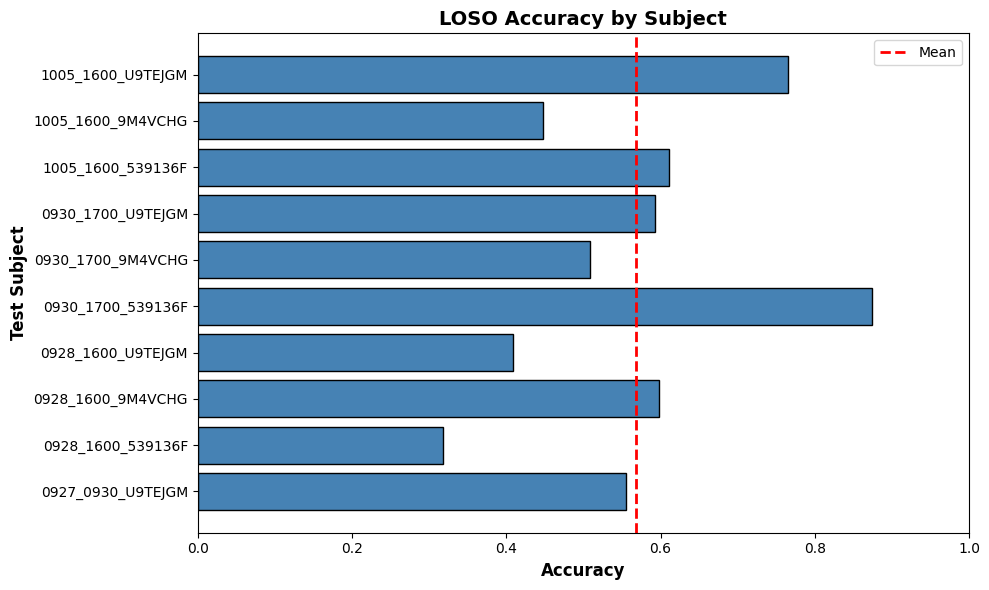

In [93]:
# =============================================================================
# LEAVE-ONE-SUBJECT-OUT (LOSO) CROSS-VALIDATION
# =============================================================================
from sklearn.model_selection import LeaveOneGroupOut

print(f"\n{'='*80}")
print(f"LEAVE-ONE-SUBJECT-OUT (LOSO) CROSS-VALIDATION")
print(f"{'='*80}")

# Prepare data
X_physio = physiology_df.drop(columns=['subject_id', 'trial_id'])[pre_cols].values # select pre-submit features only
y = outcomes
groups = subjects  # Subject IDs for grouping

# Initialize LOSO cross-validator
logo = LeaveOneGroupOut()
n_splits = logo.get_n_splits(X_physio, y, groups)

print(f"\nNumber of subjects: {len(np.unique(groups))}")
print(f"Number of LOSO splits: {n_splits}")

# Store results for each fold
loso_results = []

for fold_idx, (train_idx, test_idx) in enumerate(logo.split(X_physio, y, groups)):
    # Get train and test data
    X_train = X_physio[train_idx]
    X_test = X_physio[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]
    
    # Get the test subject ID
    test_subject = np.unique(groups[test_idx])[0]
    
    print(f"\nFold {fold_idx + 1}/{n_splits} - Test subject: {test_subject}")
    print(f"  Train samples: {len(y_train)} (KEEP: {np.sum(y_train==0)}, INVEST: {np.sum(y_train==1)})")
    print(f"  Test samples: {len(y_test)} (KEEP: {np.sum(y_test==0)}, INVEST: {np.sum(y_test==1)})")
    
    # Train model
    rf = RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced'
    )
    rf.fit(X_train, y_train)
    
    # Predictions
    y_pred = rf.predict(X_test)
    y_prob = rf.predict_proba(X_test)[:, 1]
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"  Accuracy: {accuracy:.3f} | F1: {f1:.3f}")
    
    # Store results
    loso_results.append({
        'fold': fold_idx + 1,
        'test_subject': test_subject,
        'n_train': len(y_train),
        'n_test': len(y_test),
        'accuracy': accuracy,
        'f1_score': f1,
        'y_true': y_test,
        'y_pred': y_pred,
        'y_prob': y_prob
    })

# Summary statistics
loso_df_task2_pre = pd.DataFrame(loso_results)
print(f"\n{'='*80}")
print(f"LOSO CROSS-VALIDATION SUMMARY")
print(f"{'='*80}")
print(f"\nMean Accuracy: {loso_df_task2_pre['accuracy'].mean():.3f} (+/- {loso_df_task2_pre['accuracy'].std():.3f})")
print(f"Mean F1 Score: {loso_df_task2_pre['f1_score'].mean():.3f} (+/- {loso_df_task2_pre['f1_score'].std():.3f})")
print(f"\nPer-subject results:")
print(loso_df[['test_subject', 'n_test', 'accuracy', 'f1_score']].to_string(index=False))

# Visualize LOSO results
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 1: Accuracy by subject
ax.barh(range(len(loso_df_task2_pre)), loso_df_task2_pre['accuracy'], color='steelblue', edgecolor='black')
ax.axvline(loso_df_task2_pre['accuracy'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
ax.set_yticks(range(len(loso_df_task2_pre)))
ax.set_yticklabels(loso_df_task2_pre['test_subject'])
ax.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_ylabel('Test Subject', fontsize=12, fontweight='bold')
ax.set_title('LOSO Accuracy by Subject', fontsize=14, fontweight='bold')
ax.legend()
ax.set_xlim([0, 1])

plt.tight_layout()
plt.show()

### Post predict post


LEAVE-ONE-SUBJECT-OUT (LOSO) CROSS-VALIDATION

Number of subjects: 10
Number of LOSO splits: 10

Fold 1/10 - Test subject: 0927_0930_U9TEJGM
  Train samples: 945 (KEEP: 294, INVEST: 651)
  Test samples: 99 (KEEP: 62, INVEST: 37)
  Accuracy: 0.545 | F1: 0.538

Fold 2/10 - Test subject: 0928_1600_539136F
  Train samples: 934 (KEEP: 274, INVEST: 660)
  Test samples: 110 (KEEP: 82, INVEST: 28)
  Accuracy: 0.318 | F1: 0.249

Fold 3/10 - Test subject: 0928_1600_9M4VCHG
  Train samples: 927 (KEEP: 311, INVEST: 616)
  Test samples: 117 (KEEP: 45, INVEST: 72)
  Accuracy: 0.564 | F1: 0.570

Fold 4/10 - Test subject: 0928_1600_U9TEJGM
  Train samples: 951 (KEEP: 337, INVEST: 614)
  Test samples: 93 (KEEP: 19, INVEST: 74)
  Accuracy: 0.484 | F1: 0.533

Fold 5/10 - Test subject: 0930_1700_539136F
  Train samples: 949 (KEEP: 356, INVEST: 593)
  Test samples: 95 (KEEP: 0, INVEST: 95)
  Accuracy: 0.968 | F1: 0.984

Fold 6/10 - Test subject: 0930_1700_9M4VCHG
  Train samples: 932 (KEEP: 314, INVEST: 6

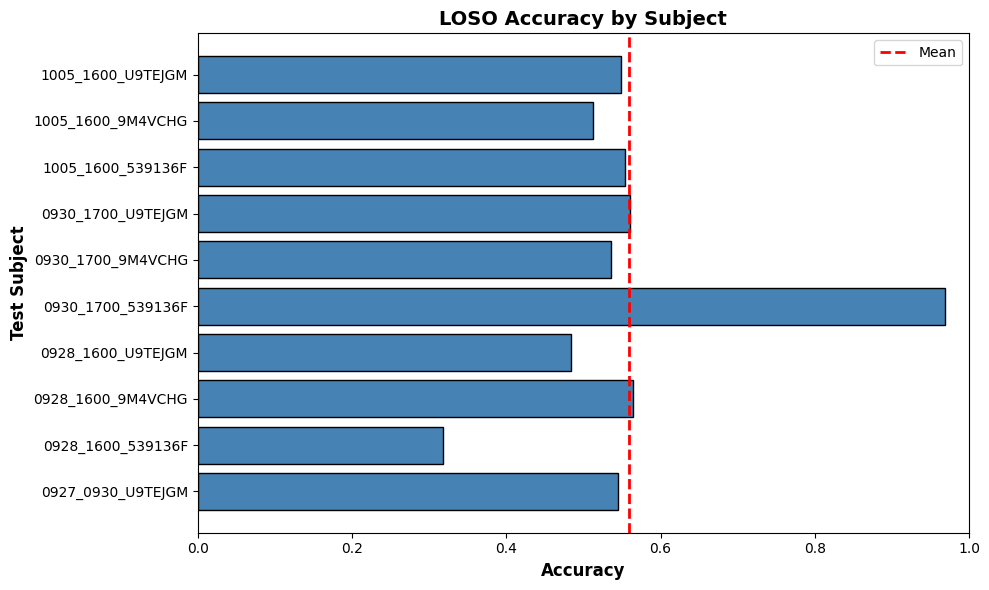

In [94]:
# =============================================================================
# LEAVE-ONE-SUBJECT-OUT (LOSO) CROSS-VALIDATION
# =============================================================================
from sklearn.model_selection import LeaveOneGroupOut

print(f"\n{'='*80}")
print(f"LEAVE-ONE-SUBJECT-OUT (LOSO) CROSS-VALIDATION")
print(f"{'='*80}")

# Prepare data
X_physio = physiology_df.drop(columns=['subject_id', 'trial_id'])[post_cols].values # select post-submit features only
y = outcomes
groups = subjects  # Subject IDs for grouping

# Initialize LOSO cross-validator
logo = LeaveOneGroupOut()
n_splits = logo.get_n_splits(X_physio, y, groups)

print(f"\nNumber of subjects: {len(np.unique(groups))}")
print(f"Number of LOSO splits: {n_splits}")

# Store results for each fold
loso_results = []

for fold_idx, (train_idx, test_idx) in enumerate(logo.split(X_physio, y, groups)):
    # Get train and test data
    X_train = X_physio[train_idx]
    X_test = X_physio[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]
    
    # Get the test subject ID
    test_subject = np.unique(groups[test_idx])[0]
    
    print(f"\nFold {fold_idx + 1}/{n_splits} - Test subject: {test_subject}")
    print(f"  Train samples: {len(y_train)} (KEEP: {np.sum(y_train==0)}, INVEST: {np.sum(y_train==1)})")
    print(f"  Test samples: {len(y_test)} (KEEP: {np.sum(y_test==0)}, INVEST: {np.sum(y_test==1)})")
    
    # Train model
    rf = RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced'
    )
    rf.fit(X_train, y_train)
    
    # Predictions
    y_pred = rf.predict(X_test)
    y_prob = rf.predict_proba(X_test)[:, 1]
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"  Accuracy: {accuracy:.3f} | F1: {f1:.3f}")
    
    # Store results
    loso_results.append({
        'fold': fold_idx + 1,
        'test_subject': test_subject,
        'n_train': len(y_train),
        'n_test': len(y_test),
        'accuracy': accuracy,
        'f1_score': f1,
        'y_true': y_test,
        'y_pred': y_pred,
        'y_prob': y_prob
    })

# Summary statistics
loso_df_task2_post = pd.DataFrame(loso_results)
print(f"\n{'='*80}")
print(f"LOSO CROSS-VALIDATION SUMMARY")
print(f"{'='*80}")
print(f"\nMean Accuracy: {loso_df_task2_post['accuracy'].mean():.3f} (+/- {loso_df_task2_post['accuracy'].std():.3f})")
print(f"Mean F1 Score: {loso_df_task2_post['f1_score'].mean():.3f} (+/- {loso_df_task2_post['f1_score'].std():.3f})")
print(f"\nPer-subject results:")
print(loso_df[['test_subject', 'n_test', 'accuracy', 'f1_score']].to_string(index=False))

# Visualize LOSO results
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 1: Accuracy by subject
ax.barh(range(len(loso_df_task2_post)), loso_df_task2_post['accuracy'], color='steelblue', edgecolor='black')
ax.axvline(loso_df_task2_post['accuracy'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
ax.set_yticks(range(len(loso_df_task2_post)))
ax.set_yticklabels(loso_df_task2_post['test_subject'])
ax.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_ylabel('Test Subject', fontsize=12, fontweight='bold')
ax.set_title('LOSO Accuracy by Subject', fontsize=14, fontweight='bold')
ax.legend()
ax.set_xlim([0, 1])

plt.tight_layout()
plt.show()

## Stratified Split

### Baseline


STRATIFIED SPLIT BY SUBJECT

Splitting with test_size=0.3
Number of subjects: 10
  0927_0930_U9TEJGM: 69 train, 30 test
  0928_1600_539136F: 77 train, 33 test
  0928_1600_9M4VCHG: 81 train, 36 test
  0928_1600_U9TEJGM: 65 train, 28 test
  0930_1700_539136F: 66 train, 29 test
  0930_1700_9M4VCHG: 78 train, 34 test
  0930_1700_U9TEJGM: 86 train, 37 test
  1005_1600_539136F: 84 train, 37 test
  1005_1600_9M4VCHG: 86 train, 37 test
  1005_1600_U9TEJGM: 35 train, 16 test

STRATIFIED SPLIT SUMMARY

Total training samples: 727 (KEEP: 247, INVEST: 480)
Total test samples: 317 (KEEP: 109, INVEST: 208)

Subject distribution in train set:
0927_0930_U9TEJGM    69
0928_1600_539136F    77
0928_1600_9M4VCHG    81
0928_1600_U9TEJGM    65
0930_1700_539136F    66
0930_1700_9M4VCHG    78
0930_1700_U9TEJGM    86
1005_1600_539136F    84
1005_1600_9M4VCHG    86
1005_1600_U9TEJGM    35
Name: count, dtype: int64

Subject distribution in test set:
0927_0930_U9TEJGM    30
0928_1600_539136F    33
0928_1600_9M4V

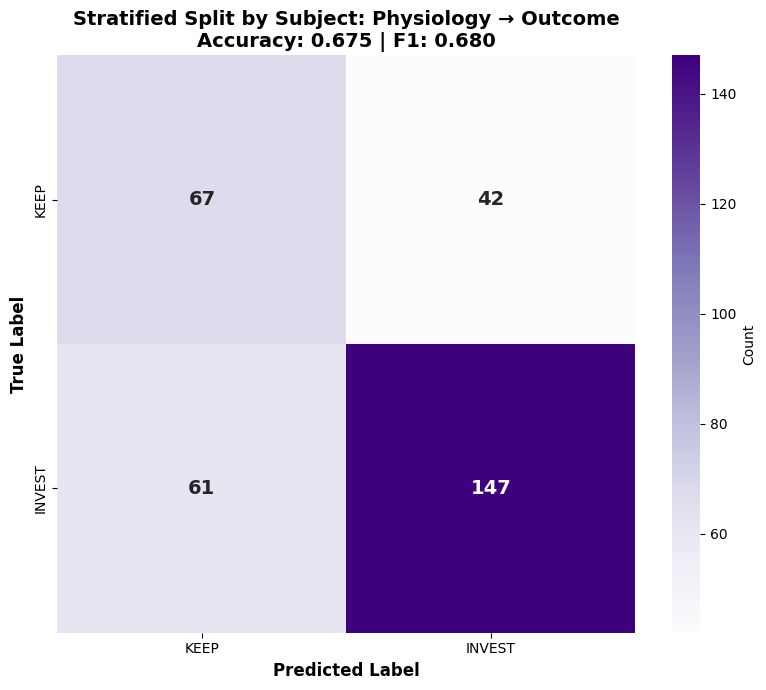


Top 10 Most Important Features (Stratified Split):
                           feature  importance
27  pupil_slope_change_pre_to_post    0.097372
16                pupil_slope_post    0.063715
2                  pupil_slope_pre    0.063629
4                 pupil_change_pre    0.054216
1                    pupil_std_pre    0.052310
3                 time_to_peak_pre    0.039902
5                     pupil_cv_pre    0.039817
12               eye_asymmetry_pre    0.036278
13           eye_asymmetry_std_pre    0.036142
22          pct_time_dilating_post    0.035125


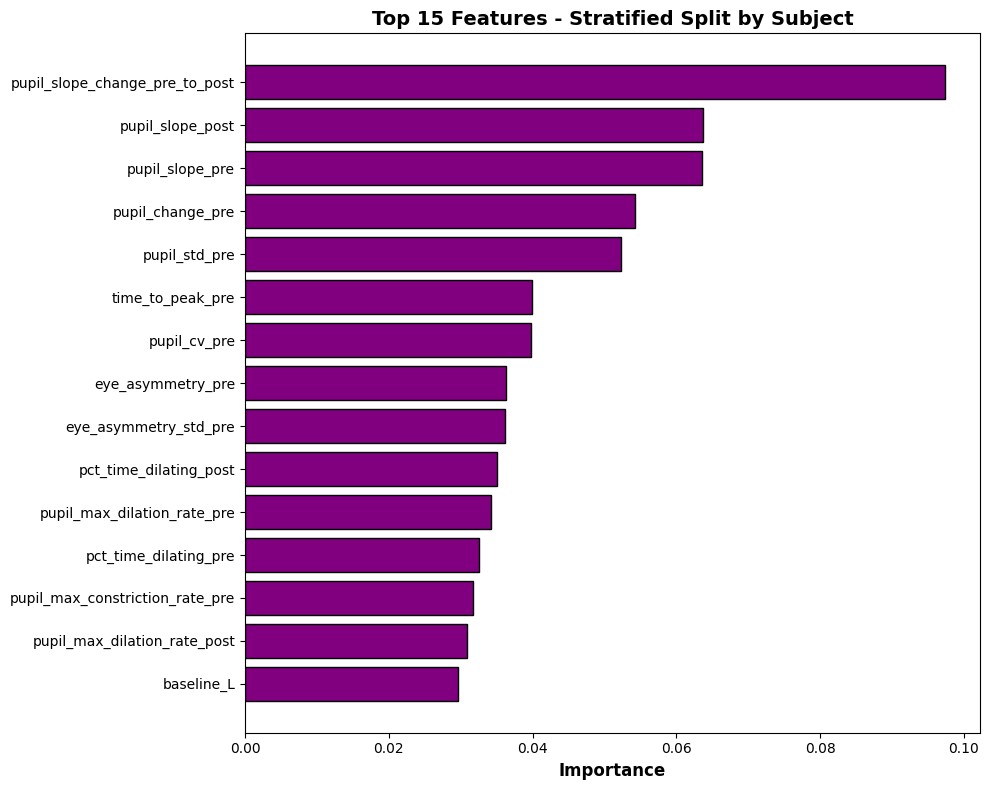

In [95]:
# =============================================================================
# STRATIFIED SPLIT BY SUBJECT (Equal % from each subject)
# =============================================================================

print(f"\n{'='*80}")
print(f"STRATIFIED SPLIT BY SUBJECT")
print(f"{'='*80}")

def stratified_split_by_subject(physiology_df, outcomes, subjects, test_size=0.3, random_state=42):
    """
    Split data ensuring equal percentage from each subject in train/test sets.
    
    Parameters:
    -----------
    physiology_df : DataFrame
        Physiology features (including subject_id and trial_id columns)
    outcomes : array
        Target labels
    subjects : array
        Subject IDs for each trial
    test_size : float
        Proportion of data to include in test split (default 0.3)
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    X_train, X_test, y_train, y_test, train_subjects, test_subjects
    """
    
    np.random.seed(random_state)
    
    train_indices = []
    test_indices = []
    
    # Get unique subjects
    unique_subjects = np.unique(subjects)
    
    print(f"\nSplitting with test_size={test_size}")
    print(f"Number of subjects: {len(unique_subjects)}")
    
    # For each subject, split their trials
    for subject in unique_subjects:
        # Get all trial indices for this subject
        subject_mask = subjects == subject
        subject_indices = np.where(subject_mask)[0]
        subject_outcomes = outcomes[subject_mask]
        
        # Stratified split for this subject to maintain class balance
        try:
            subject_train_idx, subject_test_idx = train_test_split(
                subject_indices,
                test_size=test_size,
                random_state=random_state,
                stratify=subject_outcomes
            )
        except ValueError:
            # If stratification fails (e.g., too few samples), do random split
            print(f"  Warning: Stratification failed for {subject}, using random split")
            subject_train_idx, subject_test_idx = train_test_split(
                subject_indices,
                test_size=test_size,
                random_state=random_state
            )
        
        train_indices.extend(subject_train_idx)
        test_indices.extend(subject_test_idx)
        
        print(f"  {subject}: {len(subject_train_idx)} train, {len(subject_test_idx)} test")
    
    # Convert to numpy arrays
    train_indices = np.array(train_indices)
    test_indices = np.array(test_indices)
    
    # Extract features and labels
    X_train = physiology_df.drop(columns=['subject_id', 'trial_id']).iloc[train_indices].values
    X_test = physiology_df.drop(columns=['subject_id', 'trial_id']).iloc[test_indices].values
    y_train = outcomes[train_indices]
    y_test = outcomes[test_indices]
    train_subjects = subjects[train_indices]
    test_subjects = subjects[test_indices]
    
    return X_train, X_test, y_train, y_test, train_subjects, test_subjects


# Perform stratified split
X_train_strat, X_test_strat, y_train_strat, y_test_strat, train_subjects, test_subjects = \
    stratified_split_by_subject(physiology_df, outcomes, subjects, test_size=0.3, random_state=42)

print(f"\n{'='*80}")
print(f"STRATIFIED SPLIT SUMMARY")
print(f"{'='*80}")
print(f"\nTotal training samples: {len(y_train_strat)} (KEEP: {np.sum(y_train_strat==0)}, INVEST: {np.sum(y_train_strat==1)})")
print(f"Total test samples: {len(y_test_strat)} (KEEP: {np.sum(y_test_strat==0)}, INVEST: {np.sum(y_test_strat==1)})")

# Check subject distribution in train and test
print(f"\nSubject distribution in train set:")
train_subject_counts = pd.Series(train_subjects).value_counts().sort_index()
print(train_subject_counts)

print(f"\nSubject distribution in test set:")
test_subject_counts = pd.Series(test_subjects).value_counts().sort_index()
print(test_subject_counts)

# Verify equal percentages
print(f"\nPercentage of each subject's data in test set:")
for subject in np.unique(subjects):
    total = np.sum(subjects == subject)
    test_count = np.sum(test_subjects == subject)
    pct = test_count / total
    print(f"  {subject}: {test_count}/{total} = {pct:.1%}")

# Train model
rf_strat = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced'
)
rf_strat.fit(X_train_strat, y_train_strat)

# Predictions
y_pred_strat = rf_strat.predict(X_test_strat)
y_prob_strat = rf_strat.predict_proba(X_test_strat)[:, 1]

# Evaluation
accuracy_strat = accuracy_score(y_test_strat, y_pred_strat)
f1_strat = f1_score(y_test_strat, y_pred_strat, average='weighted')

print(f"\n{'='*80}")
print(f"STRATIFIED SPLIT RESULTS")
print(f"{'='*80}")
print(f"\nAccuracy: {accuracy_strat:.3f}")
print(f"F1 Score: {f1_strat:.3f}")
print("\nClassification Report:")
print(classification_report(y_test_strat, y_pred_strat, target_names=['KEEP', 'INVEST']))

# Confusion matrix
cm_strat = confusion_matrix(y_test_strat, y_pred_strat)
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(cm_strat, annot=True, fmt='d', cmap='Purples', ax=ax, cbar_kws={'label': 'Count'},
            xticklabels=['KEEP', 'INVEST'],
            yticklabels=['KEEP', 'INVEST'], 
            annot_kws={'size': 14, 'weight': 'bold'})
ax.set_title(f'Stratified Split by Subject: Physiology → Outcome\nAccuracy: {accuracy_strat:.3f} | F1: {f1_strat:.3f}', 
             fontsize=14, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Feature importance
feature_importance_strat = pd.DataFrame({
    'feature': physiology_df.drop(columns=['subject_id', 'trial_id']).columns,
    'importance': rf_strat.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features (Stratified Split):")
print(feature_importance_strat.head(10))

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 8))
top_n = min(15, len(feature_importance_strat))
ax.barh(range(top_n), feature_importance_strat['importance'][:top_n], color='purple', edgecolor='black')
ax.set_yticks(range(top_n))
ax.set_yticklabels(feature_importance_strat['feature'][:top_n])
ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax.set_title(f'Top {top_n} Features - Stratified Split by Subject', 
             fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

### Pre predict post


STRATIFIED SPLIT BY SUBJECT

Splitting with test_size=0.3
Number of subjects: 10
  0927_0930_U9TEJGM: 69 train, 30 test
  0928_1600_539136F: 77 train, 33 test
  0928_1600_9M4VCHG: 81 train, 36 test
  0928_1600_U9TEJGM: 65 train, 28 test
  0930_1700_539136F: 66 train, 29 test
  0930_1700_9M4VCHG: 78 train, 34 test
  0930_1700_U9TEJGM: 86 train, 37 test
  1005_1600_539136F: 84 train, 37 test
  1005_1600_9M4VCHG: 86 train, 37 test
  1005_1600_U9TEJGM: 35 train, 16 test

STRATIFIED SPLIT SUMMARY

Total training samples: 727 (KEEP: 247, INVEST: 480)
Total test samples: 317 (KEEP: 109, INVEST: 208)

Subject distribution in train set:
0927_0930_U9TEJGM    69
0928_1600_539136F    77
0928_1600_9M4VCHG    81
0928_1600_U9TEJGM    65
0930_1700_539136F    66
0930_1700_9M4VCHG    78
0930_1700_U9TEJGM    86
1005_1600_539136F    84
1005_1600_9M4VCHG    86
1005_1600_U9TEJGM    35
Name: count, dtype: int64

Subject distribution in test set:
0927_0930_U9TEJGM    30
0928_1600_539136F    33
0928_1600_9M4V

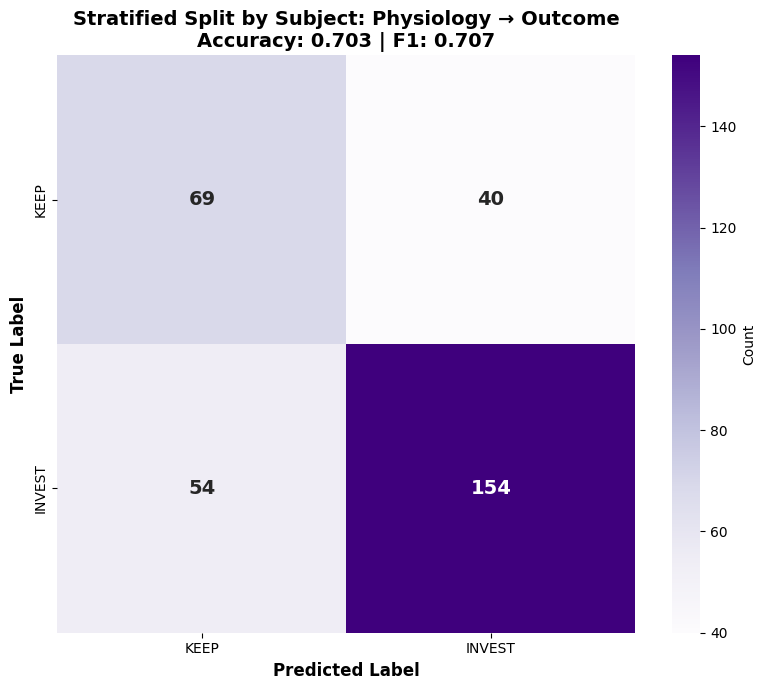


Top 10 Most Important Features (Stratified Split):
                           feature  importance
2                  pupil_slope_pre    0.129304
15  pupil_slope_change_pre_to_post    0.123023
1                    pupil_std_pre    0.066102
5                     pupil_cv_pre    0.062371
13           eye_asymmetry_std_pre    0.059794
4                 pupil_change_pre    0.059035
12               eye_asymmetry_pre    0.054632
3                 time_to_peak_pre    0.049406
16                      baseline_L    0.048111
7      pupil_max_dilation_rate_pre    0.046216


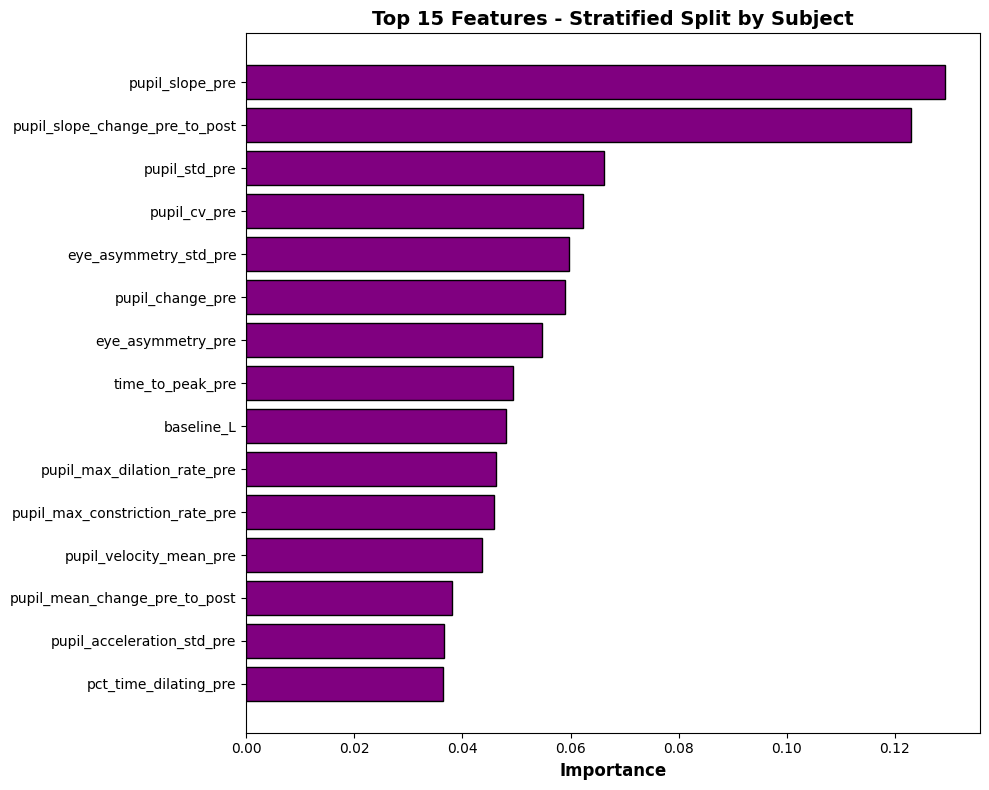

In [96]:
# =============================================================================
# STRATIFIED SPLIT BY SUBJECT (Equal % from each subject)
# =============================================================================

print(f"\n{'='*80}")
print(f"STRATIFIED SPLIT BY SUBJECT")
print(f"{'='*80}")

def stratified_split_by_subject(physiology_df, outcomes, subjects, test_size=0.3, random_state=42):
    """
    Split data ensuring equal percentage from each subject in train/test sets.
    
    Parameters:
    -----------
    physiology_df : DataFrame
        Physiology features (including subject_id and trial_id columns)
    outcomes : array
        Target labels
    subjects : array
        Subject IDs for each trial
    test_size : float
        Proportion of data to include in test split (default 0.3)
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    X_train, X_test, y_train, y_test, train_subjects, test_subjects
    """
    
    np.random.seed(random_state)
    
    train_indices = []
    test_indices = []
    
    # Get unique subjects
    unique_subjects = np.unique(subjects)
    
    print(f"\nSplitting with test_size={test_size}")
    print(f"Number of subjects: {len(unique_subjects)}")
    
    # For each subject, split their trials
    for subject in unique_subjects:
        # Get all trial indices for this subject
        subject_mask = subjects == subject
        subject_indices = np.where(subject_mask)[0]
        subject_outcomes = outcomes[subject_mask]
        
        # Stratified split for this subject to maintain class balance
        try:
            subject_train_idx, subject_test_idx = train_test_split(
                subject_indices,
                test_size=test_size,
                random_state=random_state,
                stratify=subject_outcomes
            )
        except ValueError:
            # If stratification fails (e.g., too few samples), do random split
            print(f"  Warning: Stratification failed for {subject}, using random split")
            subject_train_idx, subject_test_idx = train_test_split(
                subject_indices,
                test_size=test_size,
                random_state=random_state
            )
        
        train_indices.extend(subject_train_idx)
        test_indices.extend(subject_test_idx)
        
        print(f"  {subject}: {len(subject_train_idx)} train, {len(subject_test_idx)} test")
    
    # Convert to numpy arrays
    train_indices = np.array(train_indices)
    test_indices = np.array(test_indices)
    
    # Extract features and labels
    X_train = physiology_df.drop(columns=['subject_id', 'trial_id']).iloc[train_indices].values
    X_test = physiology_df.drop(columns=['subject_id', 'trial_id']).iloc[test_indices].values
    y_train = outcomes[train_indices]
    y_test = outcomes[test_indices]
    train_subjects = subjects[train_indices]
    test_subjects = subjects[test_indices]
    
    return X_train, X_test, y_train, y_test, train_subjects, test_subjects


# Perform stratified split
X_train_strat, X_test_strat, y_train_strat, y_test_strat, train_subjects, test_subjects = \
    stratified_split_by_subject(physiology_df_pre, outcomes, subjects, test_size=0.3, random_state=42) # use pre-submit features

print(f"\n{'='*80}")
print(f"STRATIFIED SPLIT SUMMARY")
print(f"{'='*80}")
print(f"\nTotal training samples: {len(y_train_strat)} (KEEP: {np.sum(y_train_strat==0)}, INVEST: {np.sum(y_train_strat==1)})")
print(f"Total test samples: {len(y_test_strat)} (KEEP: {np.sum(y_test_strat==0)}, INVEST: {np.sum(y_test_strat==1)})")

# Check subject distribution in train and test
print(f"\nSubject distribution in train set:")
train_subject_counts = pd.Series(train_subjects).value_counts().sort_index()
print(train_subject_counts)

print(f"\nSubject distribution in test set:")
test_subject_counts = pd.Series(test_subjects).value_counts().sort_index()
print(test_subject_counts)

# Verify equal percentages
print(f"\nPercentage of each subject's data in test set:")
for subject in np.unique(subjects):
    total = np.sum(subjects == subject)
    test_count = np.sum(test_subjects == subject)
    pct = test_count / total
    print(f"  {subject}: {test_count}/{total} = {pct:.1%}")

# Train model
rf_strat = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced'
)
rf_strat.fit(X_train_strat, y_train_strat)

# Predictions
y_pred_strat = rf_strat.predict(X_test_strat)
y_prob_strat = rf_strat.predict_proba(X_test_strat)[:, 1]

# Evaluation
accuracy_strat = accuracy_score(y_test_strat, y_pred_strat)
f1_strat = f1_score(y_test_strat, y_pred_strat, average='weighted')

print(f"\n{'='*80}")
print(f"STRATIFIED SPLIT RESULTS")
print(f"{'='*80}")
print(f"\nAccuracy: {accuracy_strat:.3f}")
print(f"F1 Score: {f1_strat:.3f}")
print("\nClassification Report:")
print(classification_report(y_test_strat, y_pred_strat, target_names=['KEEP', 'INVEST']))

# Confusion matrix
cm_strat = confusion_matrix(y_test_strat, y_pred_strat)
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(cm_strat, annot=True, fmt='d', cmap='Purples', ax=ax, cbar_kws={'label': 'Count'},
            xticklabels=['KEEP', 'INVEST'],
            yticklabels=['KEEP', 'INVEST'], 
            annot_kws={'size': 14, 'weight': 'bold'})
ax.set_title(f'Stratified Split by Subject: Physiology → Outcome\nAccuracy: {accuracy_strat:.3f} | F1: {f1_strat:.3f}', 
             fontsize=14, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Feature importance
feature_importance_strat = pd.DataFrame({
    'feature': physiology_df_pre.drop(columns=['subject_id', 'trial_id']).columns,
    'importance': rf_strat.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features (Stratified Split):")
print(feature_importance_strat.head(10))

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 8))
top_n = min(15, len(feature_importance_strat))
ax.barh(range(top_n), feature_importance_strat['importance'][:top_n], color='purple', edgecolor='black')
ax.set_yticks(range(top_n))
ax.set_yticklabels(feature_importance_strat['feature'][:top_n])
ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax.set_title(f'Top {top_n} Features - Stratified Split by Subject', 
             fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

### Post predict post


STRATIFIED SPLIT BY SUBJECT

Splitting with test_size=0.3
Number of subjects: 10
  0927_0930_U9TEJGM: 69 train, 30 test
  0928_1600_539136F: 77 train, 33 test
  0928_1600_9M4VCHG: 81 train, 36 test
  0928_1600_U9TEJGM: 65 train, 28 test
  0930_1700_539136F: 66 train, 29 test
  0930_1700_9M4VCHG: 78 train, 34 test
  0930_1700_U9TEJGM: 86 train, 37 test
  1005_1600_539136F: 84 train, 37 test
  1005_1600_9M4VCHG: 86 train, 37 test
  1005_1600_U9TEJGM: 35 train, 16 test

STRATIFIED SPLIT SUMMARY

Total training samples: 727 (KEEP: 247, INVEST: 480)
Total test samples: 317 (KEEP: 109, INVEST: 208)

Subject distribution in train set:
0927_0930_U9TEJGM    69
0928_1600_539136F    77
0928_1600_9M4VCHG    81
0928_1600_U9TEJGM    65
0930_1700_539136F    66
0930_1700_9M4VCHG    78
0930_1700_U9TEJGM    86
1005_1600_539136F    84
1005_1600_9M4VCHG    86
1005_1600_U9TEJGM    35
Name: count, dtype: int64

Subject distribution in test set:
0927_0930_U9TEJGM    30
0928_1600_539136F    33
0928_1600_9M4V

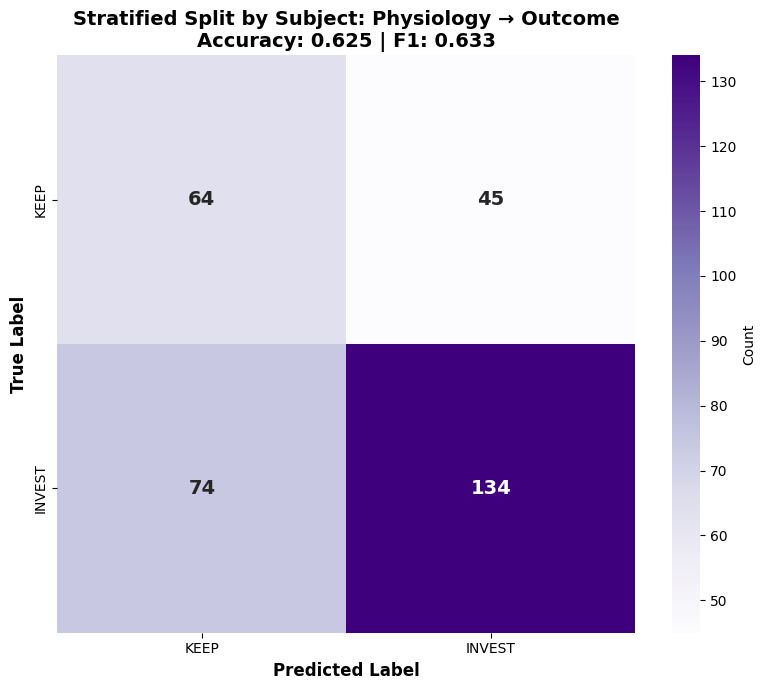


Top 10 Most Important Features (Stratified Split):
                           feature  importance
13  pupil_slope_change_pre_to_post    0.204011
2                 pupil_slope_post    0.105850
8           pct_time_dilating_post    0.073517
6     pupil_max_dilation_rate_post    0.063570
14                      baseline_L    0.057736
3                time_to_peak_post    0.057268
4                    pupil_cv_post    0.055485
10              eye_asymmetry_post    0.052905
1                   pupil_std_post    0.052780
12   pupil_mean_change_pre_to_post    0.043693


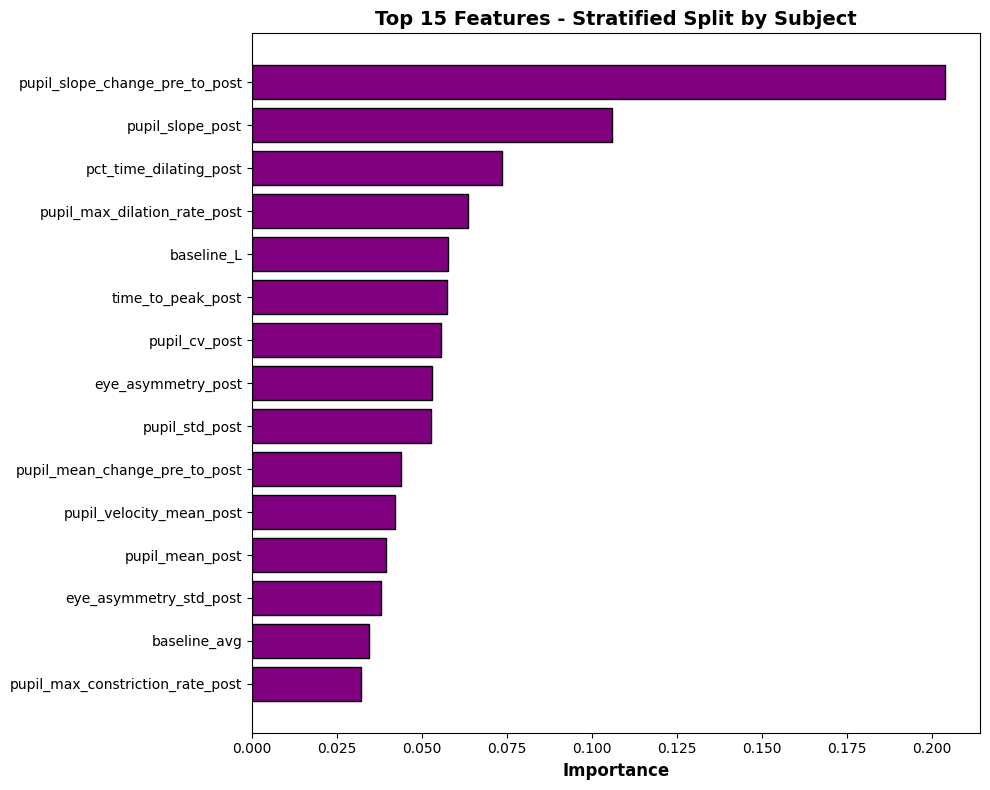

In [97]:
# =============================================================================
# STRATIFIED SPLIT BY SUBJECT (Equal % from each subject)
# =============================================================================

print(f"\n{'='*80}")
print(f"STRATIFIED SPLIT BY SUBJECT")
print(f"{'='*80}")

def stratified_split_by_subject(physiology_df, outcomes, subjects, test_size=0.3, random_state=42):
    """
    Split data ensuring equal percentage from each subject in train/test sets.
    
    Parameters:
    -----------
    physiology_df : DataFrame
        Physiology features (including subject_id and trial_id columns)
    outcomes : array
        Target labels
    subjects : array
        Subject IDs for each trial
    test_size : float
        Proportion of data to include in test split (default 0.3)
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    X_train, X_test, y_train, y_test, train_subjects, test_subjects
    """
    
    np.random.seed(random_state)
    
    train_indices = []
    test_indices = []
    
    # Get unique subjects
    unique_subjects = np.unique(subjects)
    
    print(f"\nSplitting with test_size={test_size}")
    print(f"Number of subjects: {len(unique_subjects)}")
    
    # For each subject, split their trials
    for subject in unique_subjects:
        # Get all trial indices for this subject
        subject_mask = subjects == subject
        subject_indices = np.where(subject_mask)[0]
        subject_outcomes = outcomes[subject_mask]
        
        # Stratified split for this subject to maintain class balance
        try:
            subject_train_idx, subject_test_idx = train_test_split(
                subject_indices,
                test_size=test_size,
                random_state=random_state,
                stratify=subject_outcomes
            )
        except ValueError:
            # If stratification fails (e.g., too few samples), do random split
            print(f"  Warning: Stratification failed for {subject}, using random split")
            subject_train_idx, subject_test_idx = train_test_split(
                subject_indices,
                test_size=test_size,
                random_state=random_state
            )
        
        train_indices.extend(subject_train_idx)
        test_indices.extend(subject_test_idx)
        
        print(f"  {subject}: {len(subject_train_idx)} train, {len(subject_test_idx)} test")
    
    # Convert to numpy arrays
    train_indices = np.array(train_indices)
    test_indices = np.array(test_indices)
    
    # Extract features and labels
    X_train = physiology_df.drop(columns=['subject_id', 'trial_id']).iloc[train_indices].values
    X_test = physiology_df.drop(columns=['subject_id', 'trial_id']).iloc[test_indices].values
    y_train = outcomes[train_indices]
    y_test = outcomes[test_indices]
    train_subjects = subjects[train_indices]
    test_subjects = subjects[test_indices]
    
    return X_train, X_test, y_train, y_test, train_subjects, test_subjects


# Perform stratified split
X_train_strat, X_test_strat, y_train_strat, y_test_strat, train_subjects, test_subjects = \
    stratified_split_by_subject(physiology_df_post, outcomes, subjects, test_size=0.3, random_state=42) # use pre-submit features

print(f"\n{'='*80}")
print(f"STRATIFIED SPLIT SUMMARY")
print(f"{'='*80}")
print(f"\nTotal training samples: {len(y_train_strat)} (KEEP: {np.sum(y_train_strat==0)}, INVEST: {np.sum(y_train_strat==1)})")
print(f"Total test samples: {len(y_test_strat)} (KEEP: {np.sum(y_test_strat==0)}, INVEST: {np.sum(y_test_strat==1)})")

# Check subject distribution in train and test
print(f"\nSubject distribution in train set:")
train_subject_counts = pd.Series(train_subjects).value_counts().sort_index()
print(train_subject_counts)

print(f"\nSubject distribution in test set:")
test_subject_counts = pd.Series(test_subjects).value_counts().sort_index()
print(test_subject_counts)

# Verify equal percentages
print(f"\nPercentage of each subject's data in test set:")
for subject in np.unique(subjects):
    total = np.sum(subjects == subject)
    test_count = np.sum(test_subjects == subject)
    pct = test_count / total
    print(f"  {subject}: {test_count}/{total} = {pct:.1%}")

# Train model
rf_strat = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced'
)
rf_strat.fit(X_train_strat, y_train_strat)

# Predictions
y_pred_strat = rf_strat.predict(X_test_strat)
y_prob_strat = rf_strat.predict_proba(X_test_strat)[:, 1]

# Evaluation
accuracy_strat = accuracy_score(y_test_strat, y_pred_strat)
f1_strat = f1_score(y_test_strat, y_pred_strat, average='weighted')

print(f"\n{'='*80}")
print(f"STRATIFIED SPLIT RESULTS")
print(f"{'='*80}")
print(f"\nAccuracy: {accuracy_strat:.3f}")
print(f"F1 Score: {f1_strat:.3f}")
print("\nClassification Report:")
print(classification_report(y_test_strat, y_pred_strat, target_names=['KEEP', 'INVEST']))

# Confusion matrix
cm_strat = confusion_matrix(y_test_strat, y_pred_strat)
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(cm_strat, annot=True, fmt='d', cmap='Purples', ax=ax, cbar_kws={'label': 'Count'},
            xticklabels=['KEEP', 'INVEST'],
            yticklabels=['KEEP', 'INVEST'], 
            annot_kws={'size': 14, 'weight': 'bold'})
ax.set_title(f'Stratified Split by Subject: Physiology → Outcome\nAccuracy: {accuracy_strat:.3f} | F1: {f1_strat:.3f}', 
             fontsize=14, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Feature importance
feature_importance_strat = pd.DataFrame({
    'feature': physiology_df_post.drop(columns=['subject_id', 'trial_id']).columns,
    'importance': rf_strat.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features (Stratified Split):")
print(feature_importance_strat.head(10))

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 8))
top_n = min(15, len(feature_importance_strat))
ax.barh(range(top_n), feature_importance_strat['importance'][:top_n], color='purple', edgecolor='black')
ax.set_yticks(range(top_n))
ax.set_yticklabels(feature_importance_strat['feature'][:top_n])
ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax.set_title(f'Top {top_n} Features - Stratified Split by Subject', 
             fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## Comparison


TASK 2: PHYSIOLOGY → OUTCOME - ALL METHODS COMPARISON


TASK 2 RESULTS:
      Method       Features  Accuracy  F1_Score
Random Split All (Baseline)  0.643312  0.651010
Random Split       Pre Only  0.636943  0.644077
Random Split      Post Only  0.643312  0.651805
        LOSO All (Baseline)  0.563777  0.581592
        LOSO       Pre Only  0.568017  0.586759
        LOSO      Post Only  0.559165  0.581889


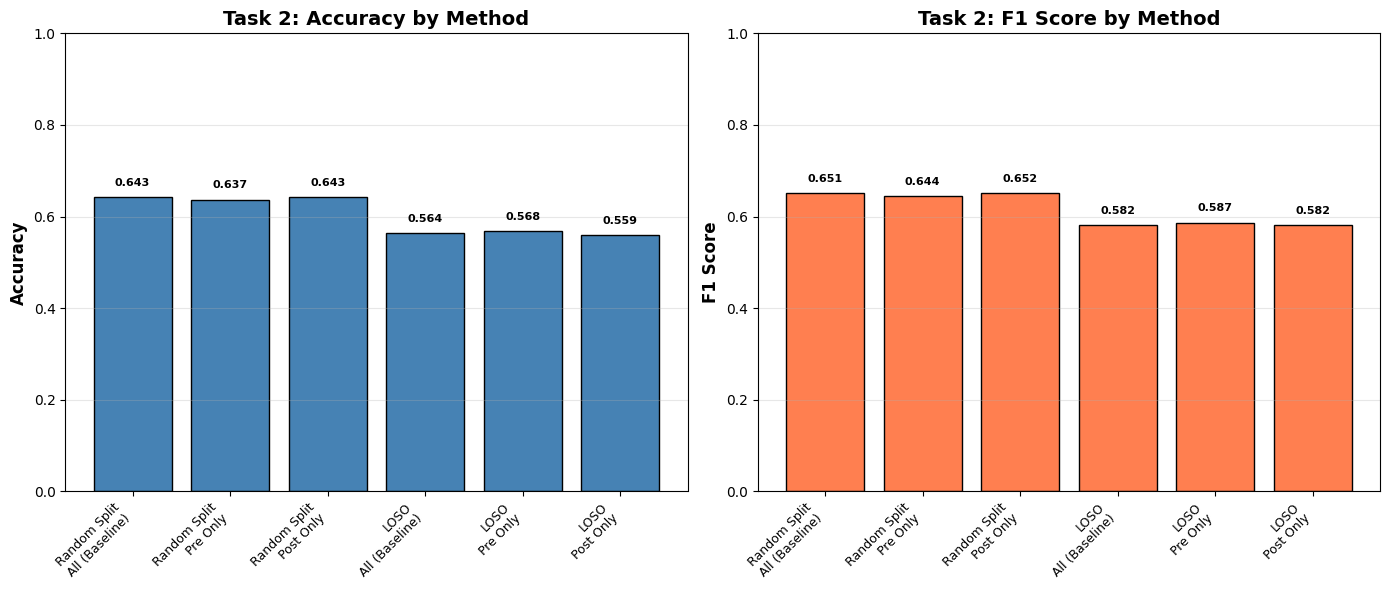


KEY FINDINGS:
Best performing: Random Split with All (Baseline) - Accuracy: 0.643


In [98]:
# =============================================================================
# TASK 2 RESULTS SUMMARY - ALL METHODS COMPARISON
# =============================================================================

print(f"\n{'='*80}")
print(f"TASK 2: PHYSIOLOGY → OUTCOME - ALL METHODS COMPARISON")
print(f"{'='*80}\n")

# Collect all Task 2 results from stored variables
task2_results = []

# Random Split - All features (baseline)
task2_results.append({'Method': 'Random Split', 'Features': 'All (Baseline)', 'Accuracy': accuracy_physio_all, 'F1_Score': f1_physio_all})

# Random Split - Pre features
task2_results.append({'Method': 'Random Split', 'Features': 'Pre Only', 'Accuracy': accuracy_physio_pre, 'F1_Score': f1_physio_pre})

# Random Split - Post features
task2_results.append({'Method': 'Random Split', 'Features': 'Post Only', 'Accuracy': accuracy_physio_post, 'F1_Score': f1_physio_post})

# LOSO - All features (if exists)
try:
    task2_results.append({'Method': 'LOSO', 'Features': 'All (Baseline)', 'Accuracy': loso_df_task2_all['accuracy'].mean(), 'F1_Score': loso_df_task2_all['f1_score'].mean()})
except:
    pass

# LOSO - Pre features (if exists)
try:
    task2_results.append({'Method': 'LOSO', 'Features': 'Pre Only', 'Accuracy': loso_df_task2_pre['accuracy'].mean(), 'F1_Score': loso_df_task2_pre['f1_score'].mean()})
except:
    pass

# LOSO - Post features (if exists)
try:
    task2_results.append({'Method': 'LOSO', 'Features': 'Post Only', 'Accuracy': loso_df_task2_post['accuracy'].mean(), 'F1_Score': loso_df_task2_post['f1_score'].mean()})
except:
    pass

# Stratified - All features (if exists)
try:
    task2_results.append({'Method': 'Stratified Split', 'Features': 'All (Baseline)', 'Accuracy': accuracy_strat_task2_all, 'F1_Score': f1_strat_task2_all})
except:
    pass

# Stratified - Pre features (if exists)
try:
    task2_results.append({'Method': 'Stratified Split', 'Features': 'Pre Only', 'Accuracy': accuracy_strat_task2_pre, 'F1_Score': f1_strat_task2_pre})
except:
    pass

# Stratified - Post features (if exists)
try:
    task2_results.append({'Method': 'Stratified Split', 'Features': 'Post Only', 'Accuracy': accuracy_strat_task2_post, 'F1_Score': f1_strat_task2_post})
except:
    pass

# Create DataFrame
task2_df = pd.DataFrame(task2_results)

print("\nTASK 2 RESULTS:")
print(task2_df.to_string(index=False))

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy comparison
x_pos = np.arange(len(task2_df))
ax1.bar(x_pos, task2_df['Accuracy'], color='steelblue', edgecolor='black')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([f"{row['Method']}\n{row['Features']}" for _, row in task2_df.iterrows()], rotation=45, ha='right', fontsize=9)
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Task 2: Accuracy by Method', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 1])
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(task2_df['Accuracy']):
    ax1.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# F1 Score comparison
ax2.bar(x_pos, task2_df['F1_Score'], color='coral', edgecolor='black')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f"{row['Method']}\n{row['Features']}" for _, row in task2_df.iterrows()], rotation=45, ha='right', fontsize=9)
ax2.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
ax2.set_title('Task 2: F1 Score by Method', fontsize=14, fontweight='bold')
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(task2_df['F1_Score']):
    ax2.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("KEY FINDINGS:")
print("="*80)
best_idx = task2_df['Accuracy'].idxmax()
best_method = task2_df.loc[best_idx, 'Method']
best_features = task2_df.loc[best_idx, 'Features']
best_accuracy = task2_df.loc[best_idx, 'Accuracy']
print(f"Best performing: {best_method} with {best_features} - Accuracy: {best_accuracy:.3f}")


# TASK 3: BEHAVIOR → OUTCOME

## Random, Balanced split


TASK 3: BEHAVIOR → OUTCOME

Training samples: 730 (KEEP: 249, INVEST: 481)
Test samples: 314 (KEEP: 107, INVEST: 207)

Accuracy: 0.662
F1 Score: 0.670

Classification Report:
              precision    recall  f1-score   support

        KEEP       0.50      0.64      0.57       107
      INVEST       0.79      0.67      0.72       207

    accuracy                           0.66       314
   macro avg       0.64      0.66      0.64       314
weighted avg       0.69      0.66      0.67       314


5-Fold Cross-Validation Accuracy: 0.688 (+/- 0.053)

Behavior Feature Importance:
            feature  importance
0     reaction_time    0.312137
1     decision_time    0.308657
4         ambiguity    0.205354
6      risk_premium    0.062794
2     ev_difference    0.053137
3   invest_variance    0.042580
5  condition_social    0.015341


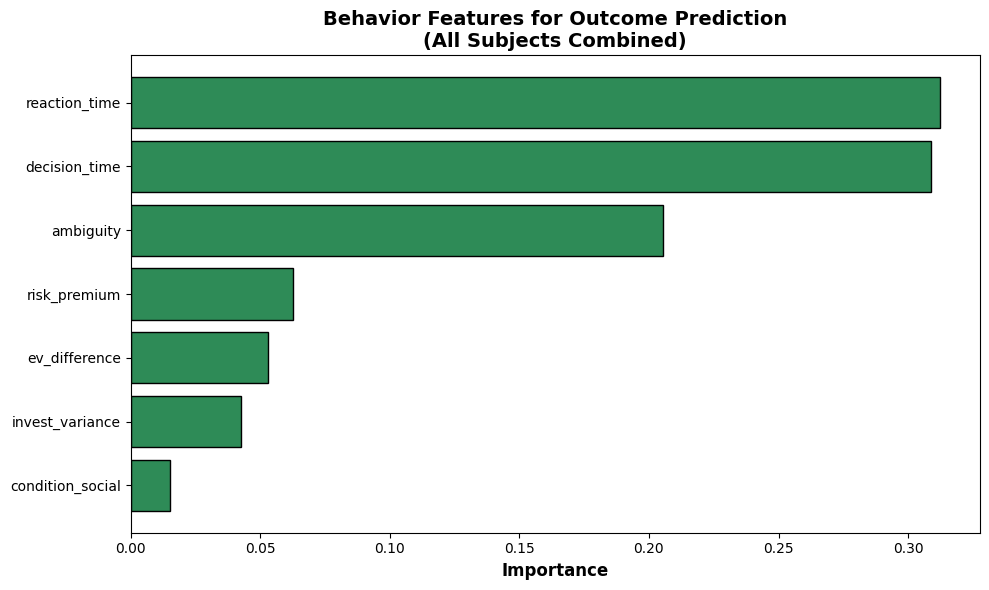

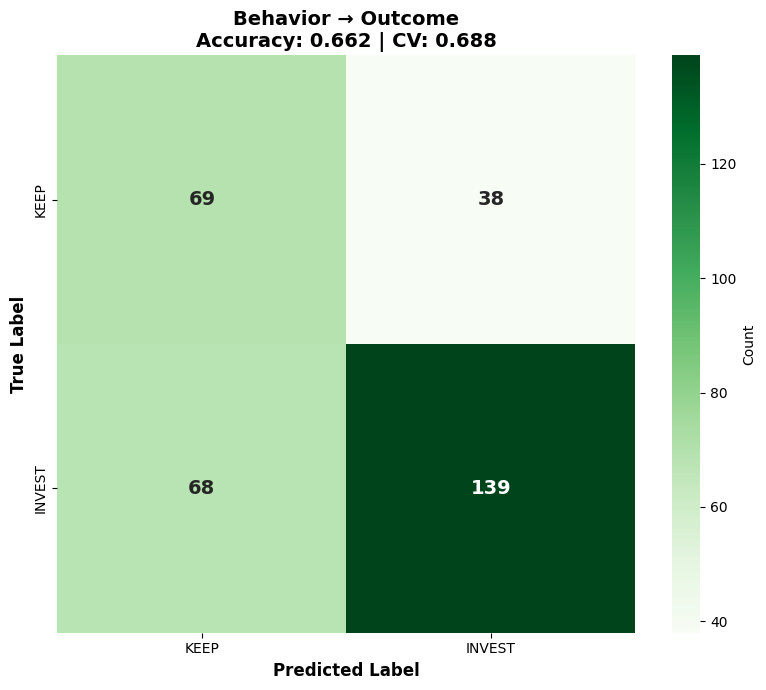

In [99]:
# =============================================================================
# TASK 3: BEHAVIOR → OUTCOME
# =============================================================================
print(f"\n{'='*80}")
print(f"TASK 3: BEHAVIOR → OUTCOME")
print(f"{'='*80}")

# Prepare data
X_behavior = behavior_df.drop(columns=['subject_id', 'trial_id']).values
y = outcomes

# Train-test split (same random state for fair comparison)
X_train_behavior, X_test_behavior, y_train, y_test = train_test_split(
    X_behavior, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTraining samples: {len(y_train)} (KEEP: {np.sum(y_train==0)}, INVEST: {np.sum(y_train==1)})")
print(f"Test samples: {len(y_test)} (KEEP: {np.sum(y_test==0)}, INVEST: {np.sum(y_test==1)})")

# Train Random Forest classifier
rf_behavior = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced'
)
rf_behavior.fit(X_train_behavior, y_train)

# Predictions
y_pred_behavior = rf_behavior.predict(X_test_behavior)
y_prob_behavior = rf_behavior.predict_proba(X_test_behavior)[:, 1]

# Evaluation
accuracy_behavior = accuracy_score(y_test, y_pred_behavior)
f1_behavior = f1_score(y_test, y_pred_behavior, average='weighted')
print(f"\nAccuracy: {accuracy_behavior:.3f}")
print(f"F1 Score: {f1_behavior:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_behavior, target_names=['KEEP', 'INVEST']))

# Cross-validation
cv_scores_behavior = cross_val_score(rf_behavior, X_behavior, y, cv=5, scoring='accuracy')
print(f"\n5-Fold Cross-Validation Accuracy: {cv_scores_behavior.mean():.3f} (+/- {cv_scores_behavior.std():.3f})")

# Feature importance
feature_importance_behavior = pd.DataFrame({
    'feature': behavior_df.drop(columns=['subject_id', 'trial_id']).columns,
    'importance': rf_behavior.feature_importances_
}).sort_values('importance', ascending=False)

print("\nBehavior Feature Importance:")
print(feature_importance_behavior)

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(range(len(feature_importance_behavior)), feature_importance_behavior['importance'], 
        color='seagreen', edgecolor='black')
ax.set_yticks(range(len(feature_importance_behavior)))
ax.set_yticklabels(feature_importance_behavior['feature'])
ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax.set_title('Behavior Features for Outcome Prediction\n(All Subjects Combined)', 
             fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

# Confusion matrix
cm_behavior = confusion_matrix(y_test, y_pred_behavior)
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(cm_behavior, annot=True, fmt='d', cmap='Greens', ax=ax, cbar_kws={'label': 'Count'},
            xticklabels=['KEEP', 'INVEST'],
            yticklabels=['KEEP', 'INVEST'],
            annot_kws={'size': 14, 'weight': 'bold'})
ax.set_title(f'Behavior → Outcome\nAccuracy: {accuracy_behavior:.3f} | CV: {cv_scores_behavior.mean():.3f}', 
             fontsize=14, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## LOSO


TASK 3: BEHAVIOR → OUTCOME - LEAVE-ONE-SUBJECT-OUT (LOSO)

Number of subjects: 10
Number of LOSO splits: 10

Fold 1/10 - Test subject: 0927_0930_U9TEJGM
  Train samples: 945 (KEEP: 294, INVEST: 651)
  Test samples: 99 (KEEP: 62, INVEST: 37)
  Accuracy: 0.677 | F1: 0.664

Fold 2/10 - Test subject: 0928_1600_539136F
  Train samples: 934 (KEEP: 274, INVEST: 660)
  Test samples: 110 (KEEP: 82, INVEST: 28)
  Accuracy: 0.509 | F1: 0.532

Fold 3/10 - Test subject: 0928_1600_9M4VCHG
  Train samples: 927 (KEEP: 311, INVEST: 616)
  Test samples: 117 (KEEP: 45, INVEST: 72)
  Accuracy: 0.615 | F1: 0.620

Fold 4/10 - Test subject: 0928_1600_U9TEJGM
  Train samples: 951 (KEEP: 337, INVEST: 614)
  Test samples: 93 (KEEP: 19, INVEST: 74)
  Accuracy: 0.656 | F1: 0.687

Fold 5/10 - Test subject: 0930_1700_539136F
  Train samples: 949 (KEEP: 356, INVEST: 593)
  Test samples: 95 (KEEP: 0, INVEST: 95)
  Accuracy: 0.863 | F1: 0.927

Fold 6/10 - Test subject: 0930_1700_9M4VCHG
  Train samples: 932 (KEEP: 31

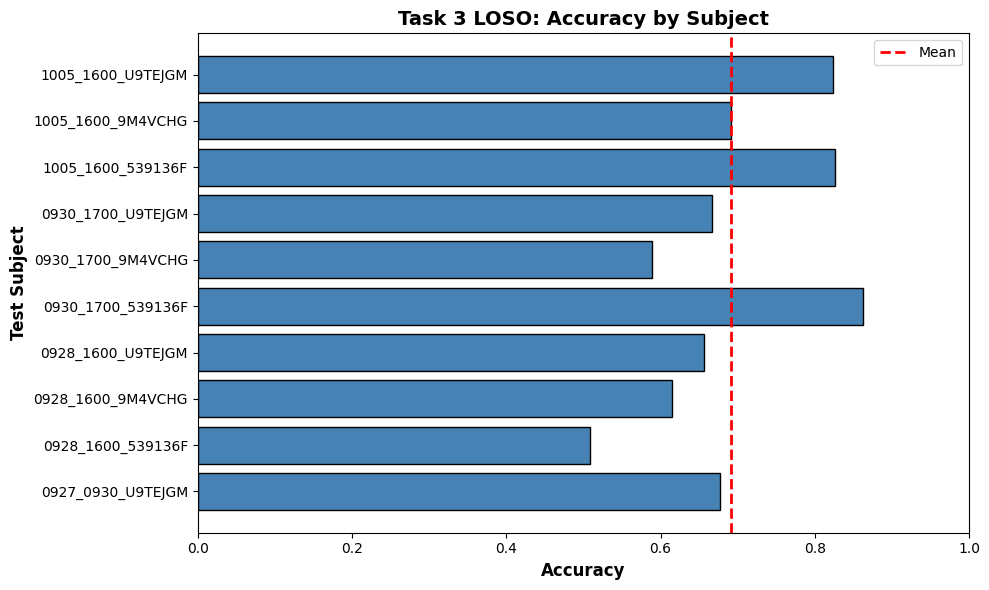

In [100]:
# =============================================================================
# TASK 3: BEHAVIOR → OUTCOME - LOSO CROSS-VALIDATION
# =============================================================================
from sklearn.model_selection import LeaveOneGroupOut

print(f"\n{'='*80}")
print(f"TASK 3: BEHAVIOR → OUTCOME - LEAVE-ONE-SUBJECT-OUT (LOSO)")
print(f"{'='*80}")

# Prepare data
X_behavior = behavior_df.drop(columns=['subject_id', 'trial_id']).values
y = outcomes
groups = subjects  # Subject IDs for grouping

# Initialize LOSO cross-validator
logo = LeaveOneGroupOut()
n_splits = logo.get_n_splits(X_behavior, y, groups)

print(f"\nNumber of subjects: {len(np.unique(groups))}")
print(f"Number of LOSO splits: {n_splits}")

# Store results for each fold
loso_results_task3 = []

for fold_idx, (train_idx, test_idx) in enumerate(logo.split(X_behavior, y, groups)):
    # Get train and test data
    X_train = X_behavior[train_idx]
    X_test = X_behavior[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]
    
    # Get the test subject ID
    test_subject = np.unique(groups[test_idx])[0]
    
    print(f"\nFold {fold_idx + 1}/{n_splits} - Test subject: {test_subject}")
    print(f"  Train samples: {len(y_train)} (KEEP: {np.sum(y_train==0)}, INVEST: {np.sum(y_train==1)})")
    print(f"  Test samples: {len(y_test)} (KEEP: {np.sum(y_test==0)}, INVEST: {np.sum(y_test==1)})")
    
    # Train model
    rf = RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced'
    )
    rf.fit(X_train, y_train)
    
    # Predictions
    y_pred = rf.predict(X_test)
    y_prob = rf.predict_proba(X_test)[:, 1]
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"  Accuracy: {accuracy:.3f} | F1: {f1:.3f}")
    
    # Store results
    loso_results_task3.append({
        'fold': fold_idx + 1,
        'test_subject': test_subject,
        'n_train': len(y_train),
        'n_test': len(y_test),
        'accuracy': accuracy,
        'f1_score': f1,
        'y_true': y_test,
        'y_pred': y_pred,
        'y_prob': y_prob
    })

# Summary statistics
loso_df_task3 = pd.DataFrame(loso_results_task3)
print(f"\n{'='*80}")
print(f"TASK 3 LOSO CROSS-VALIDATION SUMMARY")
print(f"{'='*80}")
print(f"\nMean Accuracy: {loso_df_task3['accuracy'].mean():.3f} (+/- {loso_df_task3['accuracy'].std():.3f})")
print(f"Mean F1 Score: {loso_df_task3['f1_score'].mean():.3f} (+/- {loso_df_task3['f1_score'].std():.3f})")
print(f"\nPer-subject results:")
print(loso_df_task3[['test_subject', 'n_test', 'accuracy', 'f1_score']].to_string(index=False))

# Visualize LOSO results
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 1: Accuracy by subject
ax.barh(range(len(loso_df_task3)), loso_df_task3['accuracy'], color='steelblue', edgecolor='black')
ax.axvline(loso_df_task3['accuracy'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
ax.set_yticks(range(len(loso_df_task3)))
ax.set_yticklabels(loso_df_task3['test_subject'])
ax.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_ylabel('Test Subject', fontsize=12, fontweight='bold')
ax.set_title('Task 3 LOSO: Accuracy by Subject', fontsize=14, fontweight='bold')
ax.legend()
ax.set_xlim([0, 1])

plt.tight_layout()
plt.show()


## Stratified Sample


TASK 3: BEHAVIOR → OUTCOME - STRATIFIED SPLIT BY SUBJECT

Total subjects: 10
Train samples: 727
Test samples: 317

Train distribution: KEEP=247, INVEST=480
Test distribution: KEEP=109, INVEST=208

TASK 3 STRATIFIED SPLIT RESULTS

Classification Report:
              precision    recall  f1-score   support

        KEEP       0.51      0.72      0.59       109
      INVEST       0.81      0.63      0.71       208

    accuracy                           0.66       317
   macro avg       0.66      0.68      0.65       317
weighted avg       0.71      0.66      0.67       317


Accuracy: 0.662
F1 Score: 0.671

Cross-validation scores: [0.65550239 0.70813397 0.77511962 0.61722488 0.68269231]
Mean CV Accuracy: 0.688 (+/- 0.053)

Top 10 Important Features:
         feature  importance
   decision_time    0.305154
   reaction_time    0.262850
       ambiguity    0.216491
   ev_difference    0.074823
    risk_premium    0.065685
 invest_variance    0.058273
condition_social    0.016723


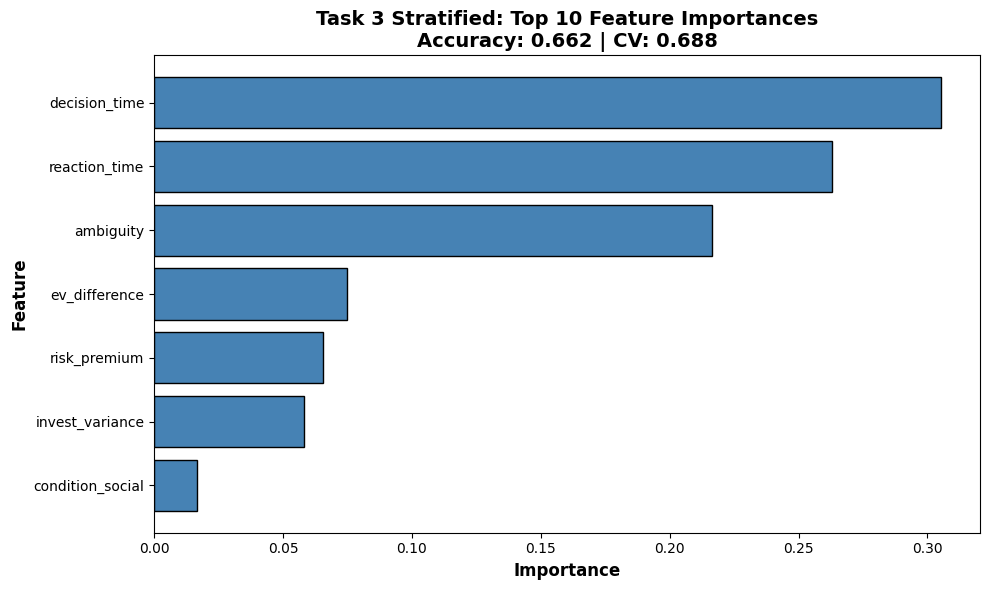

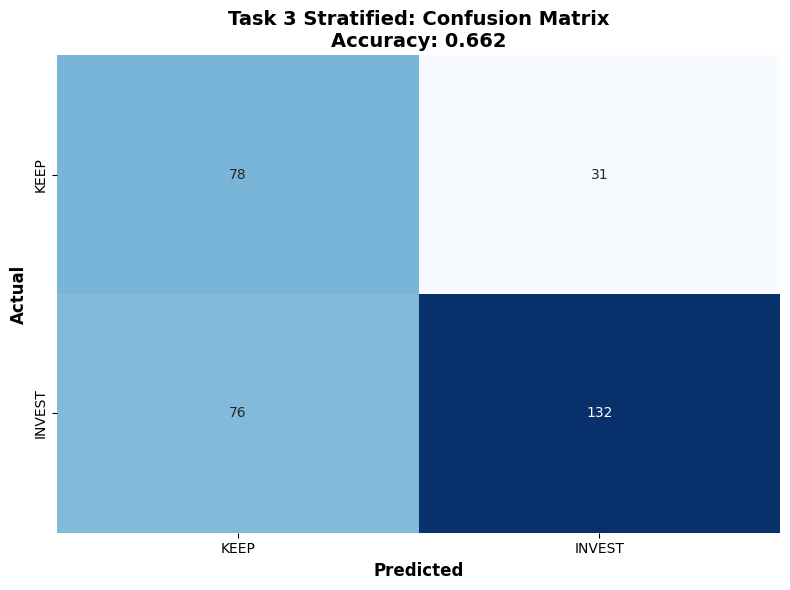

In [101]:
# =============================================================================
# TASK 3: BEHAVIOR → OUTCOME - STRATIFIED SPLIT BY SUBJECT
# =============================================================================

print(f"\n{'='*80}")
print(f"TASK 3: BEHAVIOR → OUTCOME - STRATIFIED SPLIT BY SUBJECT")
print(f"{'='*80}")

# Get unique subjects
unique_subjects = physiology_df['subject_id'].unique()
print(f"\nTotal subjects: {len(unique_subjects)}")

# For each subject, take 70% for train, 30% for test
train_indices = []
test_indices = []

for subject in unique_subjects:
    subject_mask = physiology_df['subject_id'] == subject
    subject_indices = np.where(subject_mask)[0]
    
    # Get subject's outcomes
    subject_outcomes = outcomes[subject_indices]
    
    # Stratified split for this subject
    if len(subject_indices) > 1:
        train_idx, test_idx = train_test_split(
            subject_indices, 
            test_size=0.3, 
            random_state=42,
            stratify=subject_outcomes if len(np.unique(subject_outcomes)) > 1 else None
        )
    else:
        # If only one sample, put in train
        train_idx = subject_indices
        test_idx = []
    
    train_indices.extend(train_idx)
    test_indices.extend(test_idx)

train_indices = np.array(train_indices)
test_indices = np.array(test_indices)

print(f"Train samples: {len(train_indices)}")
print(f"Test samples: {len(test_indices)}")

# Prepare behavior data
X_behavior = behavior_df.drop(columns=['subject_id', 'trial_id']).values
y = outcomes

# Split data
X_train_strat = X_behavior[train_indices]
X_test_strat = X_behavior[test_indices]
y_train_strat = y[train_indices]
y_test_strat = y[test_indices]

print(f"\nTrain distribution: KEEP={np.sum(y_train_strat==0)}, INVEST={np.sum(y_train_strat==1)}")
print(f"Test distribution: KEEP={np.sum(y_test_strat==0)}, INVEST={np.sum(y_test_strat==1)}")

# Train model
rf_strat_task3 = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced'
)

rf_strat_task3.fit(X_train_strat, y_train_strat)

# Predictions
y_pred_strat_task3 = rf_strat_task3.predict(X_test_strat)

# Evaluation
print(f"\n{'='*80}")
print(f"TASK 3 STRATIFIED SPLIT RESULTS")
print(f"{'='*80}")
print("\nClassification Report:")
print(classification_report(y_test_strat, y_pred_strat_task3, target_names=['KEEP', 'INVEST']))

accuracy_strat_task3 = accuracy_score(y_test_strat, y_pred_strat_task3)
f1_strat_task3 = f1_score(y_test_strat, y_pred_strat_task3, average='weighted')
print(f"\nAccuracy: {accuracy_strat_task3:.3f}")
print(f"F1 Score: {f1_strat_task3:.3f}")

# Cross-validation
cv_scores_strat_task3 = cross_val_score(rf_strat_task3, X_behavior, y, cv=5, scoring='accuracy')
print(f"\nCross-validation scores: {cv_scores_strat_task3}")
print(f"Mean CV Accuracy: {cv_scores_strat_task3.mean():.3f} (+/- {cv_scores_strat_task3.std():.3f})")

# Feature importance
feature_importance_strat_task3 = pd.DataFrame({
    'feature': behavior_df.drop(columns=['subject_id', 'trial_id']).columns,
    'importance': rf_strat_task3.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 Important Features:")
print(feature_importance_strat_task3.head(10).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(7), feature_importance_strat_task3['importance'].head(10)[::-1], color='steelblue', edgecolor='black')
plt.yticks(range(7), feature_importance_strat_task3['feature'].head(10)[::-1])
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title(f'Task 3 Stratified: Top 10 Feature Importances\nAccuracy: {accuracy_strat_task3:.3f} | CV: {cv_scores_strat_task3.mean():.3f}', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Confusion matrix
cm_strat_task3 = confusion_matrix(y_test_strat, y_pred_strat_task3)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_strat_task3, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['KEEP', 'INVEST'], yticklabels=['KEEP', 'INVEST'], ax=ax)
ax.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax.set_title(f'Task 3 Stratified: Confusion Matrix\nAccuracy: {accuracy_strat_task3:.3f}', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## Comparison


TASK 3: BEHAVIOR → OUTCOME - ALL METHODS COMPARISON


TASK 3 RESULTS COMPARISON:
          Method  Accuracy  F1_Score
    Random Split  0.662420  0.669987
            LOSO  0.691730  0.713237
Stratified Split  0.662461  0.670867


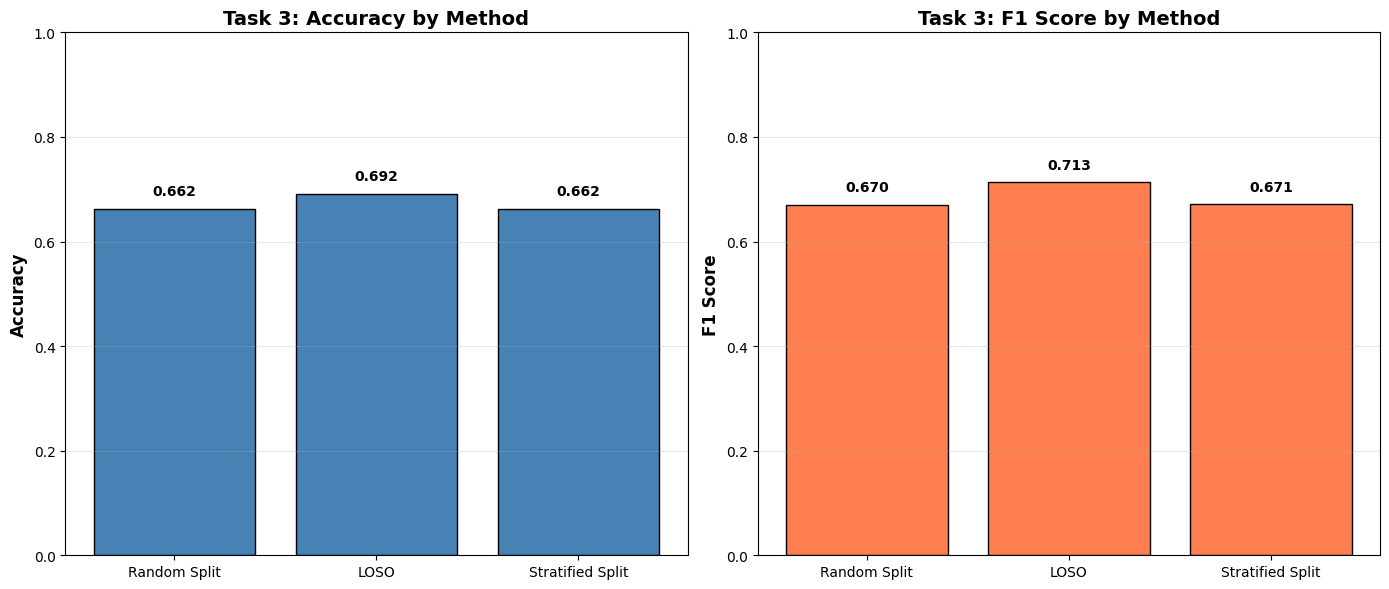


KEY FINDINGS:
Best performing method: LOSO with accuracy of 0.692


In [102]:
# =============================================================================
# TASK 3 RESULTS SUMMARY - ALL METHODS COMPARISON
# =============================================================================

print(f"\n{'='*80}")
print(f"TASK 3: BEHAVIOR → OUTCOME - ALL METHODS COMPARISON")
print(f"{'='*80}\n")

# Collect all Task 3 results from stored variables
task3_results = []

# Random Split (use stored variable)
task3_results.append({'Method': 'Random Split', 'Accuracy': accuracy_behavior, 'F1_Score': f1_behavior})

# LOSO
task3_results.append({
    'Method': 'LOSO',
    'Accuracy': loso_df_task3['accuracy'].mean(),
    'F1_Score': loso_df_task3['f1_score'].mean()
})

# Stratified Split
task3_results.append({
    'Method': 'Stratified Split',
    'Accuracy': accuracy_strat_task3,
    'F1_Score': f1_strat_task3
})

# Create DataFrame
task3_comparison_df = pd.DataFrame(task3_results)

print("\nTASK 3 RESULTS COMPARISON:")
print(task3_comparison_df.to_string(index=False))

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy comparison
x_pos = np.arange(len(task3_comparison_df))
ax1.bar(x_pos, task3_comparison_df['Accuracy'], color='steelblue', edgecolor='black')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(task3_comparison_df['Method'], rotation=0, ha='center', fontsize=10)
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Task 3: Accuracy by Method', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 1])
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(task3_comparison_df['Accuracy']):
    ax1.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# F1 Score comparison
ax2.bar(x_pos, task3_comparison_df['F1_Score'], color='coral', edgecolor='black')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(task3_comparison_df['Method'], rotation=0, ha='center', fontsize=10)
ax2.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
ax2.set_title('Task 3: F1 Score by Method', fontsize=14, fontweight='bold')
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(task3_comparison_df['F1_Score']):
    ax2.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("KEY FINDINGS:")
print("="*80)
best_method = task3_comparison_df.loc[task3_comparison_df['Accuracy'].idxmax(), 'Method']
best_accuracy = task3_comparison_df['Accuracy'].max()
print(f"Best performing method: {best_method} with accuracy of {best_accuracy:.3f}")


# TASK 4: BEHAVIOR + PHYSIOLOGY → OUTCOME (Combined)

## Random

### Baseline


TASK 4: BEHAVIOR + PHYSIOLOGY → OUTCOME (PRE FEATURES)

Combined feature shape: (1044, 38)
  - Physiology (pre): 19 features
  - Behavior: 7 features
  - Total: 38 features

Train samples: 730 (KEEP: 249, INVEST: 481)
Test samples: 314 (KEEP: 107, INVEST: 207)

TASK 4 RANDOM SPLIT (PRE) RESULTS

Classification Report:
              precision    recall  f1-score   support

        KEEP       0.55      0.66      0.60       107
      INVEST       0.81      0.72      0.76       207

    accuracy                           0.70       314
   macro avg       0.68      0.69      0.68       314
weighted avg       0.72      0.70      0.71       314


Accuracy: 0.704
F1 Score: 0.709

Cross-validation scores: [0.63157895 0.71770335 0.68421053 0.62679426 0.6875    ]
Mean CV Accuracy: 0.670 (+/- 0.035)

Top 15 Important Features:
                        feature  importance
                  decision_time    0.130748
                  reaction_time    0.111425
                      ambiguity    0.103

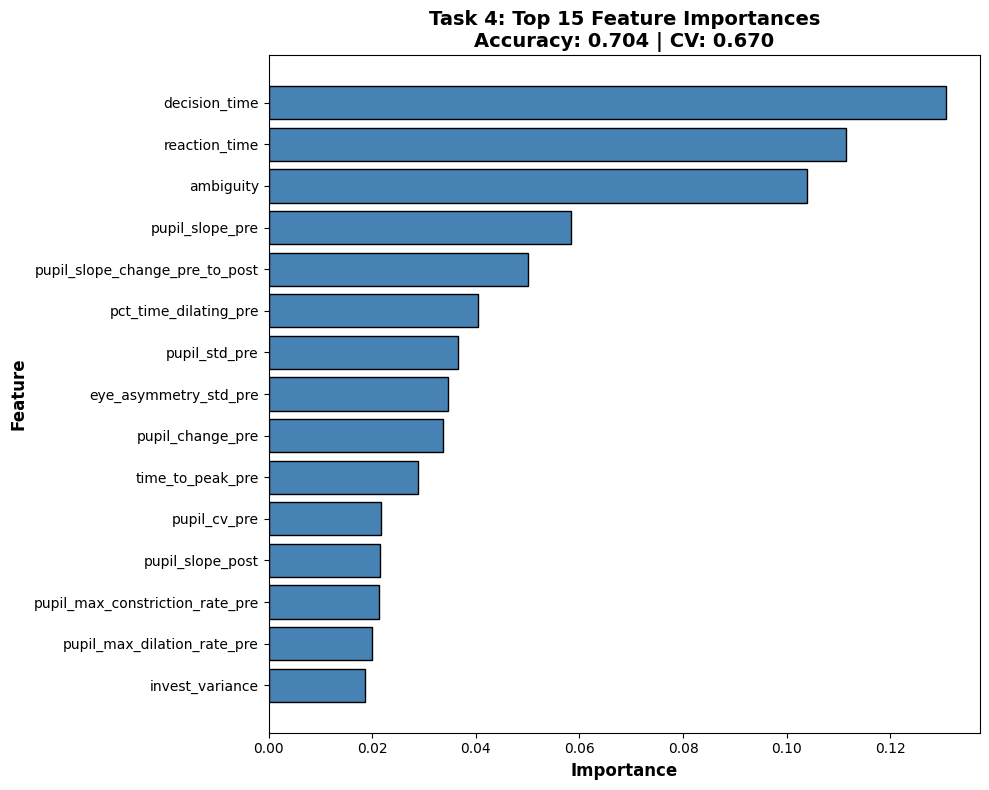

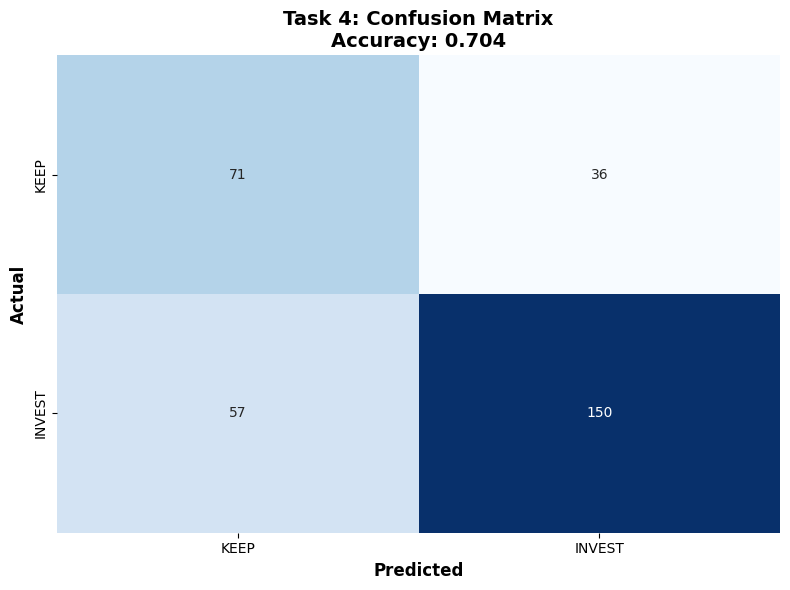

In [103]:
# =============================================================================
# TASK 4: BEHAVIOR + PHYSIOLOGY → OUTCOME - RANDOM SPLIT (Pre Features)
# =============================================================================

print(f"\n{'='*80}")
print(f"TASK 4: BEHAVIOR + PHYSIOLOGY → OUTCOME (PRE FEATURES)")
print(f"{'='*80}")

# Combine physiology features and behavior features
physio_features = physiology_df.drop(columns=['subject_id', 'trial_id'])
behavior_features = behavior_df.drop(columns=['subject_id', 'trial_id'])

# Concatenate features
X_combined = pd.concat([physio_features, behavior_features], axis=1)
print(f"\nCombined feature shape: {X_combined.shape}")
print(f"  - Physiology (pre): {len(pre_cols)} features")
print(f"  - Behavior: {behavior_features.shape[1]} features")
print(f"  - Total: {X_combined.shape[1]} features")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_combined.values, outcomes, test_size=0.3, random_state=42, stratify=outcomes
)

print(f"\nTrain samples: {len(y_train)} (KEEP: {np.sum(y_train==0)}, INVEST: {np.sum(y_train==1)})")
print(f"Test samples: {len(y_test)} (KEEP: {np.sum(y_test==0)}, INVEST: {np.sum(y_test==1)})")

# Train Random Forest
rf_combined = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced'
)

rf_combined.fit(X_train, y_train)

# Predictions
y_pred_combined = rf_combined.predict(X_test)

# Evaluation
print(f"\n{'='*80}")
print(f"TASK 4 RANDOM SPLIT (PRE) RESULTS")
print(f"{'='*80}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_combined, target_names=['KEEP', 'INVEST']))

accuracy_combined = accuracy_score(y_test, y_pred_combined)
f1_combined = f1_score(y_test, y_pred_combined, average='weighted')
print(f"\nAccuracy: {accuracy_combined:.3f}")
print(f"F1 Score: {f1_combined:.3f}")

# Cross-validation
cv_scores_combined = cross_val_score(rf_combined, X_combined.values, outcomes, cv=5, scoring='accuracy')
print(f"\nCross-validation scores: {cv_scores_combined}")
print(f"Mean CV Accuracy: {cv_scores_combined.mean():.3f} (+/- {cv_scores_combined.std():.3f})")

# Feature importance
feature_importance_combined = pd.DataFrame({
    'feature': X_combined.columns,
    'importance': rf_combined.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 15 Important Features:")
print(feature_importance_combined.head(15).to_string(index=False))

# Visualize feature importance (top 15)
plt.figure(figsize=(10, 8))
plt.barh(range(15), feature_importance_combined['importance'].head(15)[::-1], color='steelblue', edgecolor='black')
plt.yticks(range(15), feature_importance_combined['feature'].head(15)[::-1])
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title(f'Task 4: Top 15 Feature Importances\nAccuracy: {accuracy_combined:.3f} | CV: {cv_scores_combined.mean():.3f}',
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Confusion matrix
cm_combined_pre = confusion_matrix(y_test, y_pred_combined)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_combined_pre, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['KEEP', 'INVEST'], yticklabels=['KEEP', 'INVEST'], ax=ax)
ax.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax.set_title(f'Task 4: Confusion Matrix\nAccuracy: {accuracy_combined:.3f}',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Pre predict post


TASK 4: BEHAVIOR + PHYSIOLOGY → OUTCOME (PRE FEATURES)

Combined feature shape: (1044, 26)
  - Physiology (pre): 19 features
  - Behavior: 7 features
  - Total: 26 features

Train samples: 730 (KEEP: 249, INVEST: 481)
Test samples: 314 (KEEP: 107, INVEST: 207)

TASK 4 RANDOM SPLIT (PRE) RESULTS

Classification Report:
              precision    recall  f1-score   support

        KEEP       0.56      0.67      0.61       107
      INVEST       0.81      0.73      0.77       207

    accuracy                           0.71       314
   macro avg       0.69      0.70      0.69       314
weighted avg       0.73      0.71      0.72       314


Accuracy: 0.710
F1 Score: 0.715

Cross-validation scores: [0.6076555  0.72248804 0.65550239 0.6076555  0.67788462]
Mean CV Accuracy: 0.654 (+/- 0.044)

Top 15 Important Features:
                        feature  importance
                  reaction_time    0.152508
                  decision_time    0.151671
                      ambiguity    0.090

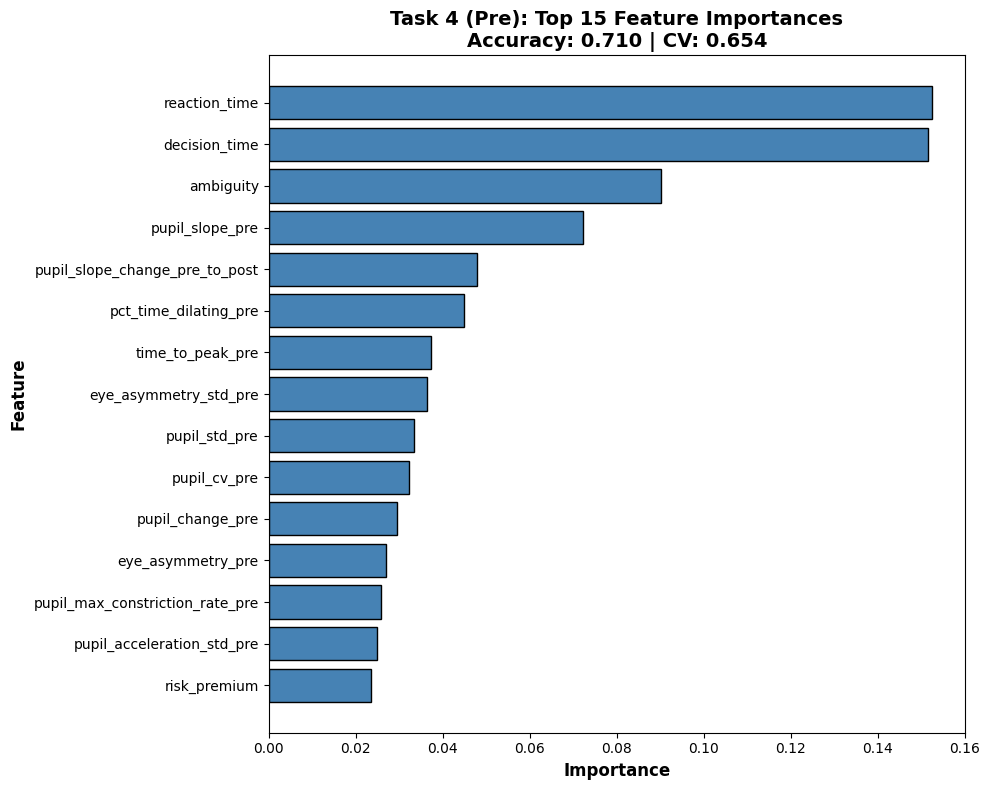

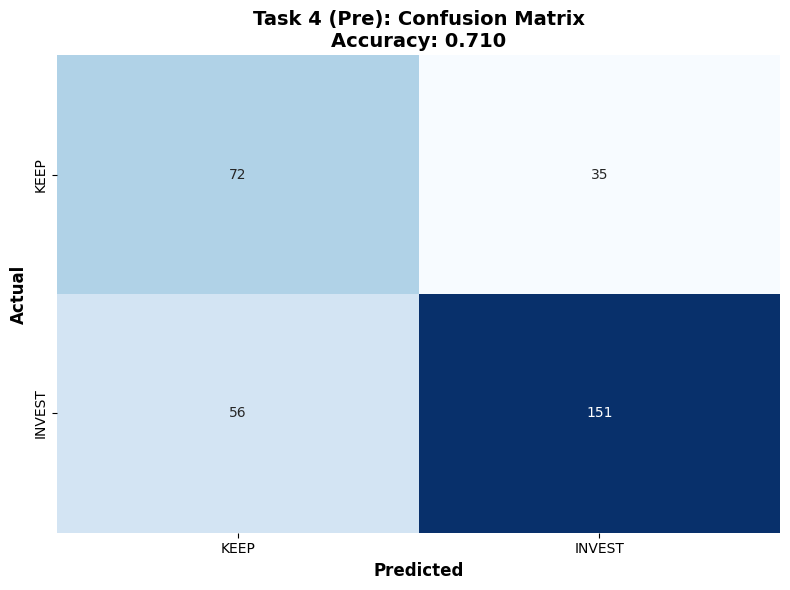

In [104]:
# =============================================================================
# TASK 4: BEHAVIOR + PHYSIOLOGY → OUTCOME - RANDOM SPLIT (Pre Features)
# =============================================================================

print(f"\n{'='*80}")
print(f"TASK 4: BEHAVIOR + PHYSIOLOGY → OUTCOME (PRE FEATURES)")
print(f"{'='*80}")

# Combine physiology PRE features and behavior features
physio_pre_features = physiology_df.drop(columns=['subject_id', 'trial_id'])[pre_cols]
behavior_features = behavior_df.drop(columns=['subject_id', 'trial_id'])

# Concatenate features
X_combined_pre = pd.concat([physio_pre_features, behavior_features], axis=1)
print(f"\nCombined feature shape: {X_combined_pre.shape}")
print(f"  - Physiology (pre): {len(pre_cols)} features")
print(f"  - Behavior: {behavior_features.shape[1]} features")
print(f"  - Total: {X_combined_pre.shape[1]} features")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_combined_pre.values, outcomes, test_size=0.3, random_state=42, stratify=outcomes
)

print(f"\nTrain samples: {len(y_train)} (KEEP: {np.sum(y_train==0)}, INVEST: {np.sum(y_train==1)})")
print(f"Test samples: {len(y_test)} (KEEP: {np.sum(y_test==0)}, INVEST: {np.sum(y_test==1)})")

# Train Random Forest
rf_combined_pre = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced'
)

rf_combined_pre.fit(X_train, y_train)

# Predictions
y_pred_combined_pre = rf_combined_pre.predict(X_test)

# Evaluation
print(f"\n{'='*80}")
print(f"TASK 4 RANDOM SPLIT (PRE) RESULTS")
print(f"{'='*80}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_combined_pre, target_names=['KEEP', 'INVEST']))

accuracy_combined_pre = accuracy_score(y_test, y_pred_combined_pre)
f1_combined_pre = f1_score(y_test, y_pred_combined_pre, average='weighted')
print(f"\nAccuracy: {accuracy_combined_pre:.3f}")
print(f"F1 Score: {f1_combined_pre:.3f}")

# Cross-validation
cv_scores_combined_pre = cross_val_score(rf_combined_pre, X_combined_pre.values, outcomes, cv=5, scoring='accuracy')
print(f"\nCross-validation scores: {cv_scores_combined_pre}")
print(f"Mean CV Accuracy: {cv_scores_combined_pre.mean():.3f} (+/- {cv_scores_combined_pre.std():.3f})")

# Feature importance
feature_importance_combined_pre = pd.DataFrame({
    'feature': X_combined_pre.columns,
    'importance': rf_combined_pre.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 15 Important Features:")
print(feature_importance_combined_pre.head(15).to_string(index=False))

# Visualize feature importance (top 15)
plt.figure(figsize=(10, 8))
plt.barh(range(15), feature_importance_combined_pre['importance'].head(15)[::-1], color='steelblue', edgecolor='black')
plt.yticks(range(15), feature_importance_combined_pre['feature'].head(15)[::-1])
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title(f'Task 4 (Pre): Top 15 Feature Importances\nAccuracy: {accuracy_combined_pre:.3f} | CV: {cv_scores_combined_pre.mean():.3f}',
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Confusion matrix
cm_combined_pre = confusion_matrix(y_test, y_pred_combined_pre)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_combined_pre, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['KEEP', 'INVEST'], yticklabels=['KEEP', 'INVEST'], ax=ax)
ax.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax.set_title(f'Task 4 (Pre): Confusion Matrix\nAccuracy: {accuracy_combined_pre:.3f}',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


### Post predict post


TASK 4: BEHAVIOR + PHYSIOLOGY → OUTCOME (POST FEATURES)

Combined feature shape: (1044, 24)
  - Physiology (post): 17 features
  - Behavior: 7 features
  - Total: 24 features

Train samples: 730 (KEEP: 249, INVEST: 481)
Test samples: 314 (KEEP: 107, INVEST: 207)

TASK 4 RANDOM SPLIT (POST) RESULTS

Classification Report:
              precision    recall  f1-score   support

        KEEP       0.52      0.66      0.58       107
      INVEST       0.80      0.69      0.74       207

    accuracy                           0.68       314
   macro avg       0.66      0.67      0.66       314
weighted avg       0.70      0.68      0.69       314


Accuracy: 0.678
F1 Score: 0.685

Cross-validation scores: [0.64114833 0.75598086 0.70813397 0.6507177  0.71153846]
Mean CV Accuracy: 0.694 (+/- 0.042)

Top 15 Important Features:
                       feature  importance
                 reaction_time    0.157724
                 decision_time    0.144821
                     ambiguity    0.1352

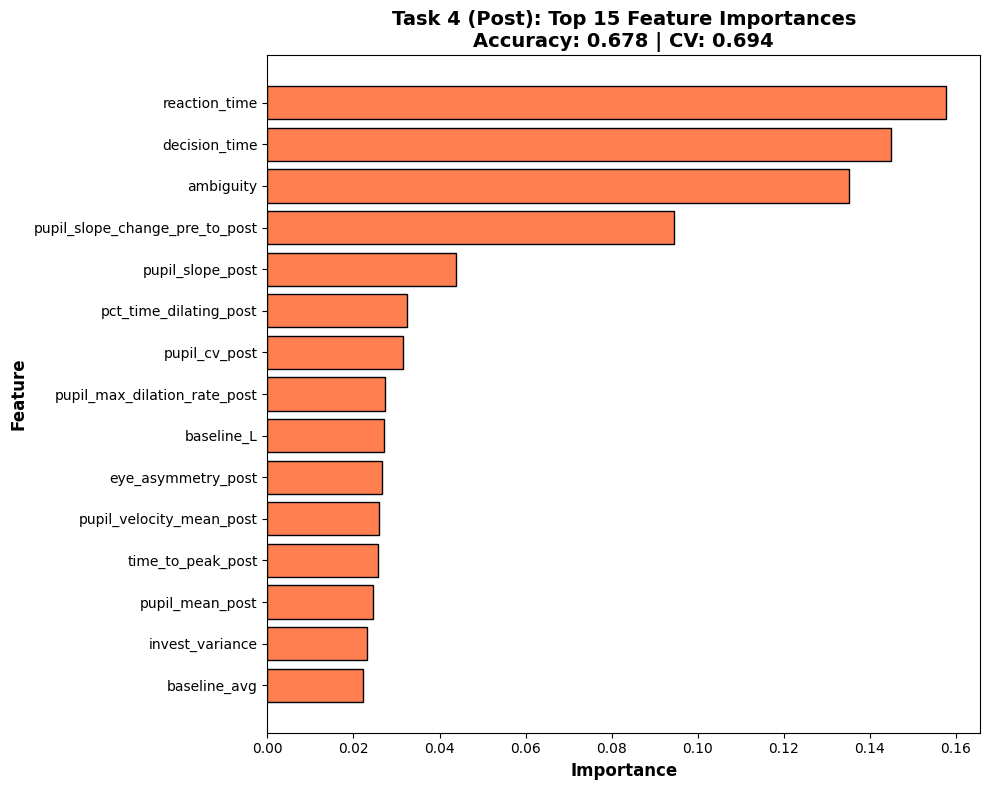

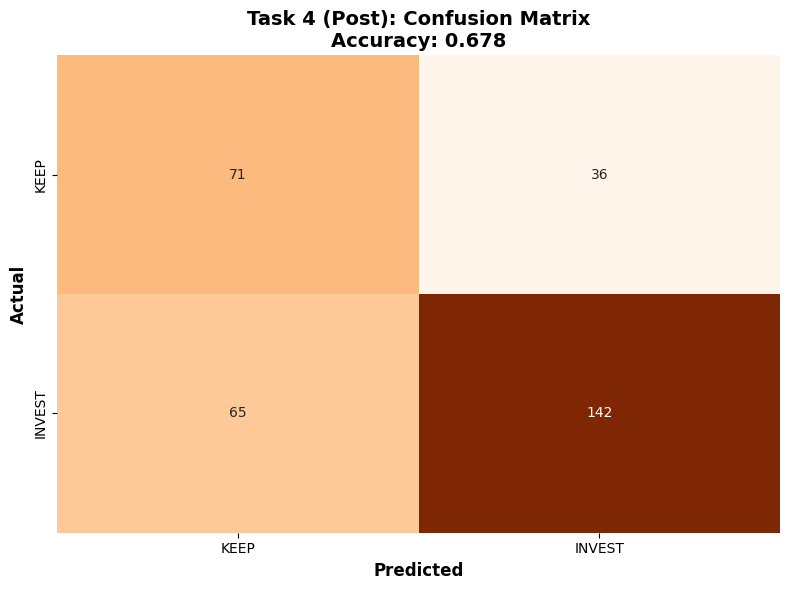

In [105]:
# =============================================================================
# TASK 4: BEHAVIOR + PHYSIOLOGY → OUTCOME - RANDOM SPLIT (Post Features)
# =============================================================================

print(f"\n{'='*80}")
print(f"TASK 4: BEHAVIOR + PHYSIOLOGY → OUTCOME (POST FEATURES)")
print(f"{'='*80}")

# Combine physiology POST features and behavior features
physio_post_features = physiology_df.drop(columns=['subject_id', 'trial_id'])[post_cols]
behavior_features = behavior_df.drop(columns=['subject_id', 'trial_id'])

# Concatenate features
X_combined_post = pd.concat([physio_post_features, behavior_features], axis=1)
print(f"\nCombined feature shape: {X_combined_post.shape}")
print(f"  - Physiology (post): {len(post_cols)} features")
print(f"  - Behavior: {behavior_features.shape[1]} features")
print(f"  - Total: {X_combined_post.shape[1]} features")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_combined_post.values, outcomes, test_size=0.3, random_state=42, stratify=outcomes
)

print(f"\nTrain samples: {len(y_train)} (KEEP: {np.sum(y_train==0)}, INVEST: {np.sum(y_train==1)})")
print(f"Test samples: {len(y_test)} (KEEP: {np.sum(y_test==0)}, INVEST: {np.sum(y_test==1)})")

# Train Random Forest
rf_combined_post = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced'
)

rf_combined_post.fit(X_train, y_train)

# Predictions
y_pred_combined_post = rf_combined_post.predict(X_test)

# Evaluation
print(f"\n{'='*80}")
print(f"TASK 4 RANDOM SPLIT (POST) RESULTS")
print(f"{'='*80}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_combined_post, target_names=['KEEP', 'INVEST']))

accuracy_combined_post = accuracy_score(y_test, y_pred_combined_post)
f1_combined_post = f1_score(y_test, y_pred_combined_post, average='weighted')
print(f"\nAccuracy: {accuracy_combined_post:.3f}")
print(f"F1 Score: {f1_combined_post:.3f}")

# Cross-validation
cv_scores_combined_post = cross_val_score(rf_combined_post, X_combined_post.values, outcomes, cv=5, scoring='accuracy')
print(f"\nCross-validation scores: {cv_scores_combined_post}")
print(f"Mean CV Accuracy: {cv_scores_combined_post.mean():.3f} (+/- {cv_scores_combined_post.std():.3f})")

# Feature importance
feature_importance_combined_post = pd.DataFrame({
    'feature': X_combined_post.columns,
    'importance': rf_combined_post.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 15 Important Features:")
print(feature_importance_combined_post.head(15).to_string(index=False))

# Visualize feature importance (top 15)
plt.figure(figsize=(10, 8))
plt.barh(range(15), feature_importance_combined_post['importance'].head(15)[::-1], color='coral', edgecolor='black')
plt.yticks(range(15), feature_importance_combined_post['feature'].head(15)[::-1])
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title(f'Task 4 (Post): Top 15 Feature Importances\nAccuracy: {accuracy_combined_post:.3f} | CV: {cv_scores_combined_post.mean():.3f}',
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Confusion matrix
cm_combined_post = confusion_matrix(y_test, y_pred_combined_post)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_combined_post, annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=['KEEP', 'INVEST'], yticklabels=['KEEP', 'INVEST'], ax=ax)
ax.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax.set_title(f'Task 4 (Post): Confusion Matrix\nAccuracy: {accuracy_combined_post:.3f}',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## LOSO

### Baseline


TASK 4: BEHAVIOR + PHYSIOLOGY → OUTCOME - LOSO

Number of subjects: 10
Number of LOSO splits: 10

Fold 1/10 - Test subject: 0927_0930_U9TEJGM
  Train samples: 945 (KEEP: 294, INVEST: 651)
  Test samples: 99 (KEEP: 62, INVEST: 37)
  Accuracy: 0.677 | F1: 0.667

Fold 2/10 - Test subject: 0928_1600_539136F
  Train samples: 934 (KEEP: 274, INVEST: 660)
  Test samples: 110 (KEEP: 82, INVEST: 28)
  Accuracy: 0.391 | F1: 0.355

Fold 3/10 - Test subject: 0928_1600_9M4VCHG
  Train samples: 927 (KEEP: 311, INVEST: 616)
  Test samples: 117 (KEEP: 45, INVEST: 72)
  Accuracy: 0.607 | F1: 0.612

Fold 4/10 - Test subject: 0928_1600_U9TEJGM
  Train samples: 951 (KEEP: 337, INVEST: 614)
  Test samples: 93 (KEEP: 19, INVEST: 74)
  Accuracy: 0.602 | F1: 0.634

Fold 5/10 - Test subject: 0930_1700_539136F
  Train samples: 949 (KEEP: 356, INVEST: 593)
  Test samples: 95 (KEEP: 0, INVEST: 95)
  Accuracy: 0.989 | F1: 0.995

Fold 6/10 - Test subject: 0930_1700_9M4VCHG
  Train samples: 932 (KEEP: 314, INVEST: 

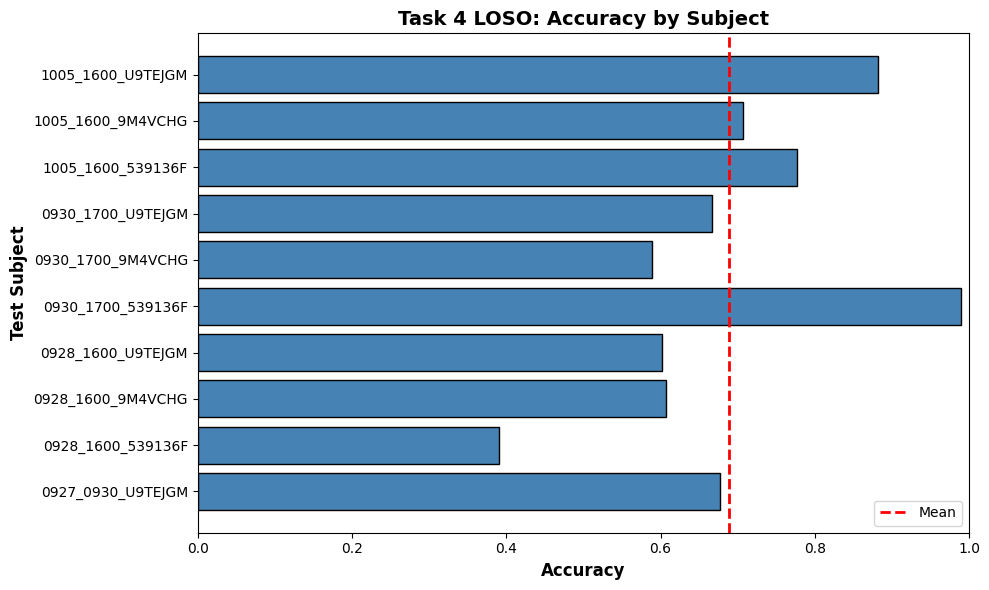

In [106]:
# =============================================================================
# TASK 4: BEHAVIOR + PHYSIOLOGY → OUTCOME - LOSO 
# =============================================================================
from sklearn.model_selection import LeaveOneGroupOut

print(f"\n{'='*80}")
print(f"TASK 4: BEHAVIOR + PHYSIOLOGY → OUTCOME - LOSO")
print(f"{'='*80}")

# Prepare combined data
X_combined_array = X_combined.values
y = outcomes
groups = subjects

# Initialize LOSO cross-validator
logo = LeaveOneGroupOut()
n_splits = logo.get_n_splits(X_combined_array, y, groups)

print(f"\nNumber of subjects: {len(np.unique(groups))}")
print(f"Number of LOSO splits: {n_splits}")

# Store results for each fold
loso_results_task4 = []

for fold_idx, (train_idx, test_idx) in enumerate(logo.split(X_combined_array, y, groups)):
    # Get train and test data
    X_train = X_combined_array[train_idx]
    X_test = X_combined_array[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]
    
    # Get the test subject ID
    test_subject = np.unique(groups[test_idx])[0]
    
    print(f"\nFold {fold_idx + 1}/{n_splits} - Test subject: {test_subject}")
    print(f"  Train samples: {len(y_train)} (KEEP: {np.sum(y_train==0)}, INVEST: {np.sum(y_train==1)})")
    print(f"  Test samples: {len(y_test)} (KEEP: {np.sum(y_test==0)}, INVEST: {np.sum(y_test==1)})")
    
    # Train model
    rf = RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced'
    )
    rf.fit(X_train, y_train)
    
    # Predictions
    y_pred = rf.predict(X_test)
    y_prob = rf.predict_proba(X_test)[:, 1]
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"  Accuracy: {accuracy:.3f} | F1: {f1:.3f}")
    
    # Store results
    loso_results_task4.append({
        'fold': fold_idx + 1,
        'test_subject': test_subject,
        'n_train': len(y_train),
        'n_test': len(y_test),
        'accuracy': accuracy,
        'f1_score': f1
    })

# Summary statistics
loso_df_task4 = pd.DataFrame(loso_results_task4)
print(f"\n{'='*80}")
print(f"TASK 4 LOSO SUMMARY")
print(f"{'='*80}")
print(f"\nMean Accuracy: {loso_df_task4['accuracy'].mean():.3f} (+/- {loso_df_task4['accuracy'].std():.3f})")
print(f"Mean F1 Score: {loso_df_task4['f1_score'].mean():.3f} (+/- {loso_df_task4['f1_score'].std():.3f})")
print(f"\nPer-subject results:")
print(loso_df_task4[['test_subject', 'n_test', 'accuracy', 'f1_score']].to_string(index=False))

# Visualize LOSO results
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 1: Accuracy by subject
ax.barh(range(len(loso_df_task4)), loso_df_task4['accuracy'], color='steelblue', edgecolor='black')
ax.axvline(loso_df_task4['accuracy'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
ax.set_yticks(range(len(loso_df_task4)))
ax.set_yticklabels(loso_df_task4['test_subject'])
ax.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_ylabel('Test Subject', fontsize=12, fontweight='bold')
ax.set_title('Task 4 LOSO: Accuracy by Subject', fontsize=14, fontweight='bold')
ax.legend()
ax.set_xlim([0, 1])

plt.tight_layout()
plt.show()

### Pre predict post


TASK 4: BEHAVIOR + PHYSIOLOGY → OUTCOME - LOSO (PRE)

Number of subjects: 10
Number of LOSO splits: 10

Fold 1/10 - Test subject: 0927_0930_U9TEJGM
  Train samples: 945 (KEEP: 294, INVEST: 651)
  Test samples: 99 (KEEP: 62, INVEST: 37)
  Accuracy: 0.687 | F1: 0.672

Fold 2/10 - Test subject: 0928_1600_539136F
  Train samples: 934 (KEEP: 274, INVEST: 660)
  Test samples: 110 (KEEP: 82, INVEST: 28)
  Accuracy: 0.373 | F1: 0.335

Fold 3/10 - Test subject: 0928_1600_9M4VCHG
  Train samples: 927 (KEEP: 311, INVEST: 616)
  Test samples: 117 (KEEP: 45, INVEST: 72)
  Accuracy: 0.650 | F1: 0.654

Fold 4/10 - Test subject: 0928_1600_U9TEJGM
  Train samples: 951 (KEEP: 337, INVEST: 614)
  Test samples: 93 (KEEP: 19, INVEST: 74)
  Accuracy: 0.581 | F1: 0.612

Fold 5/10 - Test subject: 0930_1700_539136F
  Train samples: 949 (KEEP: 356, INVEST: 593)
  Test samples: 95 (KEEP: 0, INVEST: 95)
  Accuracy: 0.979 | F1: 0.989

Fold 6/10 - Test subject: 0930_1700_9M4VCHG
  Train samples: 932 (KEEP: 314, IN

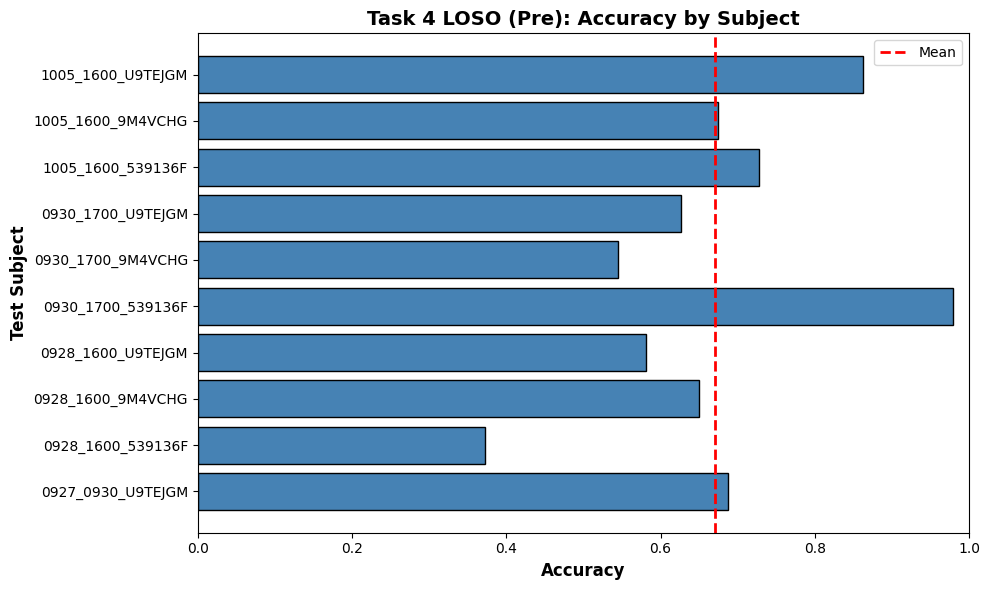

In [107]:
# =============================================================================
# TASK 4: BEHAVIOR + PHYSIOLOGY → OUTCOME - LOSO (Pre Features)
# =============================================================================
from sklearn.model_selection import LeaveOneGroupOut

print(f"\n{'='*80}")
print(f"TASK 4: BEHAVIOR + PHYSIOLOGY → OUTCOME - LOSO (PRE)")
print(f"{'='*80}")

# Prepare combined data
X_combined_pre_array = X_combined_pre.values
y = outcomes
groups = subjects

# Initialize LOSO cross-validator
logo = LeaveOneGroupOut()
n_splits = logo.get_n_splits(X_combined_pre_array, y, groups)

print(f"\nNumber of subjects: {len(np.unique(groups))}")
print(f"Number of LOSO splits: {n_splits}")

# Store results for each fold
loso_results_task4_pre = []

for fold_idx, (train_idx, test_idx) in enumerate(logo.split(X_combined_pre_array, y, groups)):
    # Get train and test data
    X_train = X_combined_pre_array[train_idx]
    X_test = X_combined_pre_array[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]
    
    # Get the test subject ID
    test_subject = np.unique(groups[test_idx])[0]
    
    print(f"\nFold {fold_idx + 1}/{n_splits} - Test subject: {test_subject}")
    print(f"  Train samples: {len(y_train)} (KEEP: {np.sum(y_train==0)}, INVEST: {np.sum(y_train==1)})")
    print(f"  Test samples: {len(y_test)} (KEEP: {np.sum(y_test==0)}, INVEST: {np.sum(y_test==1)})")
    
    # Train model
    rf = RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced'
    )
    rf.fit(X_train, y_train)
    
    # Predictions
    y_pred = rf.predict(X_test)
    y_prob = rf.predict_proba(X_test)[:, 1]
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"  Accuracy: {accuracy:.3f} | F1: {f1:.3f}")
    
    # Store results
    loso_results_task4_pre.append({
        'fold': fold_idx + 1,
        'test_subject': test_subject,
        'n_train': len(y_train),
        'n_test': len(y_test),
        'accuracy': accuracy,
        'f1_score': f1
    })

# Summary statistics
loso_df_task4_pre = pd.DataFrame(loso_results_task4_pre)
print(f"\n{'='*80}")
print(f"TASK 4 LOSO (PRE) SUMMARY")
print(f"{'='*80}")
print(f"\nMean Accuracy: {loso_df_task4_pre['accuracy'].mean():.3f} (+/- {loso_df_task4_pre['accuracy'].std():.3f})")
print(f"Mean F1 Score: {loso_df_task4_pre['f1_score'].mean():.3f} (+/- {loso_df_task4_pre['f1_score'].std():.3f})")
print(f"\nPer-subject results:")
print(loso_df_task4_pre[['test_subject', 'n_test', 'accuracy', 'f1_score']].to_string(index=False))

# Visualize LOSO results
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 1: Accuracy by subject
ax.barh(range(len(loso_df_task4_pre)), loso_df_task4_pre['accuracy'], color='steelblue', edgecolor='black')
ax.axvline(loso_df_task4_pre['accuracy'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
ax.set_yticks(range(len(loso_df_task4_pre)))
ax.set_yticklabels(loso_df_task4_pre['test_subject'])
ax.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_ylabel('Test Subject', fontsize=12, fontweight='bold')
ax.set_title('Task 4 LOSO (Pre): Accuracy by Subject', fontsize=14, fontweight='bold')
ax.legend()
ax.set_xlim([0, 1])

plt.tight_layout()
plt.show()


### Post predict post


TASK 4: BEHAVIOR + PHYSIOLOGY → OUTCOME - LOSO (POST)

Number of subjects: 10
Number of LOSO splits: 10

Fold 1/10 - Test subject: 0927_0930_U9TEJGM
  Train samples: 945 (KEEP: 294, INVEST: 651)
  Test samples: 99 (KEEP: 62, INVEST: 37)
  Accuracy: 0.667 | F1: 0.647

Fold 2/10 - Test subject: 0928_1600_539136F
  Train samples: 934 (KEEP: 274, INVEST: 660)
  Test samples: 110 (KEEP: 82, INVEST: 28)
  Accuracy: 0.427 | F1: 0.439

Fold 3/10 - Test subject: 0928_1600_9M4VCHG
  Train samples: 927 (KEEP: 311, INVEST: 616)
  Test samples: 117 (KEEP: 45, INVEST: 72)
  Accuracy: 0.667 | F1: 0.671

Fold 4/10 - Test subject: 0928_1600_U9TEJGM
  Train samples: 951 (KEEP: 337, INVEST: 614)
  Test samples: 93 (KEEP: 19, INVEST: 74)
  Accuracy: 0.667 | F1: 0.698

Fold 5/10 - Test subject: 0930_1700_539136F
  Train samples: 949 (KEEP: 356, INVEST: 593)
  Test samples: 95 (KEEP: 0, INVEST: 95)
  Accuracy: 0.968 | F1: 0.984

Fold 6/10 - Test subject: 0930_1700_9M4VCHG
  Train samples: 932 (KEEP: 314, I

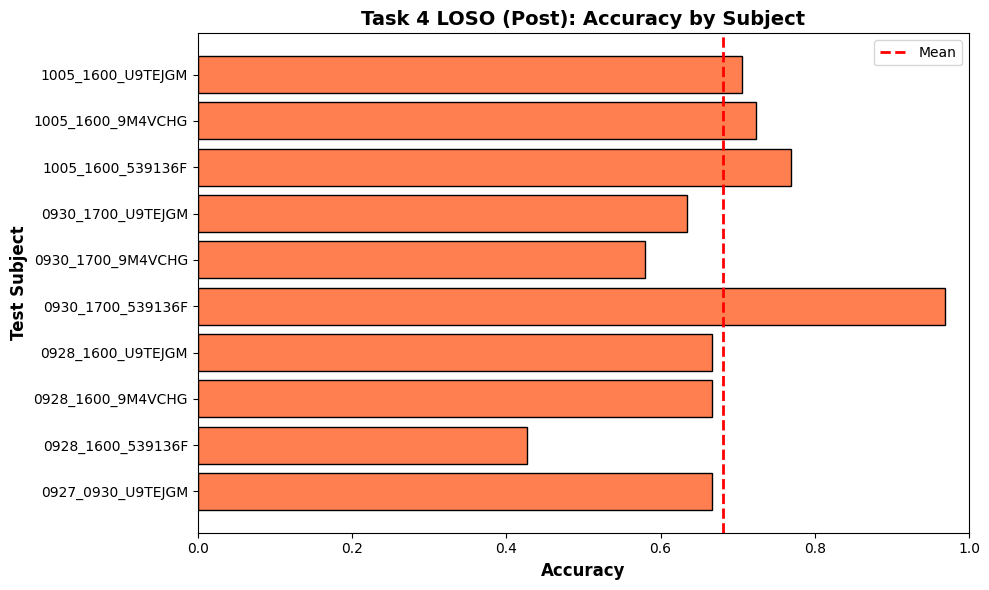

In [108]:
# =============================================================================
# TASK 4: BEHAVIOR + PHYSIOLOGY → OUTCOME - LOSO (Post Features)
# =============================================================================
from sklearn.model_selection import LeaveOneGroupOut

print(f"\n{'='*80}")
print(f"TASK 4: BEHAVIOR + PHYSIOLOGY → OUTCOME - LOSO (POST)")
print(f"{'='*80}")

# Prepare combined data
X_combined_post_array = X_combined_post.values
y = outcomes
groups = subjects

# Initialize LOSO cross-validator
logo = LeaveOneGroupOut()
n_splits = logo.get_n_splits(X_combined_post_array, y, groups)

print(f"\nNumber of subjects: {len(np.unique(groups))}")
print(f"Number of LOSO splits: {n_splits}")

# Store results for each fold
loso_results_task4_post = []

for fold_idx, (train_idx, test_idx) in enumerate(logo.split(X_combined_post_array, y, groups)):
    # Get train and test data
    X_train = X_combined_post_array[train_idx]
    X_test = X_combined_post_array[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]
    
    # Get the test subject ID
    test_subject = np.unique(groups[test_idx])[0]
    
    print(f"\nFold {fold_idx + 1}/{n_splits} - Test subject: {test_subject}")
    print(f"  Train samples: {len(y_train)} (KEEP: {np.sum(y_train==0)}, INVEST: {np.sum(y_train==1)})")
    print(f"  Test samples: {len(y_test)} (KEEP: {np.sum(y_test==0)}, INVEST: {np.sum(y_test==1)})")
    
    # Train model
    rf = RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced'
    )
    rf.fit(X_train, y_train)
    
    # Predictions
    y_pred = rf.predict(X_test)
    y_prob = rf.predict_proba(X_test)[:, 1]
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"  Accuracy: {accuracy:.3f} | F1: {f1:.3f}")
    
    # Store results
    loso_results_task4_post.append({
        'fold': fold_idx + 1,
        'test_subject': test_subject,
        'n_train': len(y_train),
        'n_test': len(y_test),
        'accuracy': accuracy,
        'f1_score': f1
    })

# Summary statistics
loso_df_task4_post = pd.DataFrame(loso_results_task4_post)
print(f"\n{'='*80}")
print(f"TASK 4 LOSO (POST) SUMMARY")
print(f"{'='*80}")
print(f"\nMean Accuracy: {loso_df_task4_post['accuracy'].mean():.3f} (+/- {loso_df_task4_post['accuracy'].std():.3f})")
print(f"Mean F1 Score: {loso_df_task4_post['f1_score'].mean():.3f} (+/- {loso_df_task4_post['f1_score'].std():.3f})")
print(f"\nPer-subject results:")
print(loso_df_task4_post[['test_subject', 'n_test', 'accuracy', 'f1_score']].to_string(index=False))

# Visualize LOSO results
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 1: Accuracy by subject
ax.barh(range(len(loso_df_task4_post)), loso_df_task4_post['accuracy'], color='coral', edgecolor='black')
ax.axvline(loso_df_task4_post['accuracy'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
ax.set_yticks(range(len(loso_df_task4_post)))
ax.set_yticklabels(loso_df_task4_post['test_subject'])
ax.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_ylabel('Test Subject', fontsize=12, fontweight='bold')
ax.set_title('Task 4 LOSO (Post): Accuracy by Subject', fontsize=14, fontweight='bold')
ax.legend()
ax.set_xlim([0, 1])

plt.tight_layout()
plt.show()


## Stratified

### Baseline


TASK 4: BEHAVIOR + PHYSIOLOGY → OUTCOME - STRATIFIED
Train samples: 727
Test samples: 317

Train distribution: KEEP=247, INVEST=480
Test distribution: KEEP=109, INVEST=208

TASK 4 STRATIFIED RESULTS

Classification Report:
              precision    recall  f1-score   support

        KEEP       0.56      0.74      0.64       109
      INVEST       0.84      0.70      0.76       208

    accuracy                           0.71       317
   macro avg       0.70      0.72      0.70       317
weighted avg       0.74      0.71      0.72       317


Accuracy: 0.713
F1 Score: 0.720

Cross-validation scores: [0.63157895 0.71770335 0.68421053 0.62679426 0.6875    ]
Mean CV Accuracy: 0.670 (+/- 0.035)

Top 15 Important Features:
                       feature  importance
                 decision_time    0.129933
                     ambiguity    0.114365
                 reaction_time    0.102469
pupil_slope_change_pre_to_post    0.060663
                 pupil_std_pre    0.038722
           

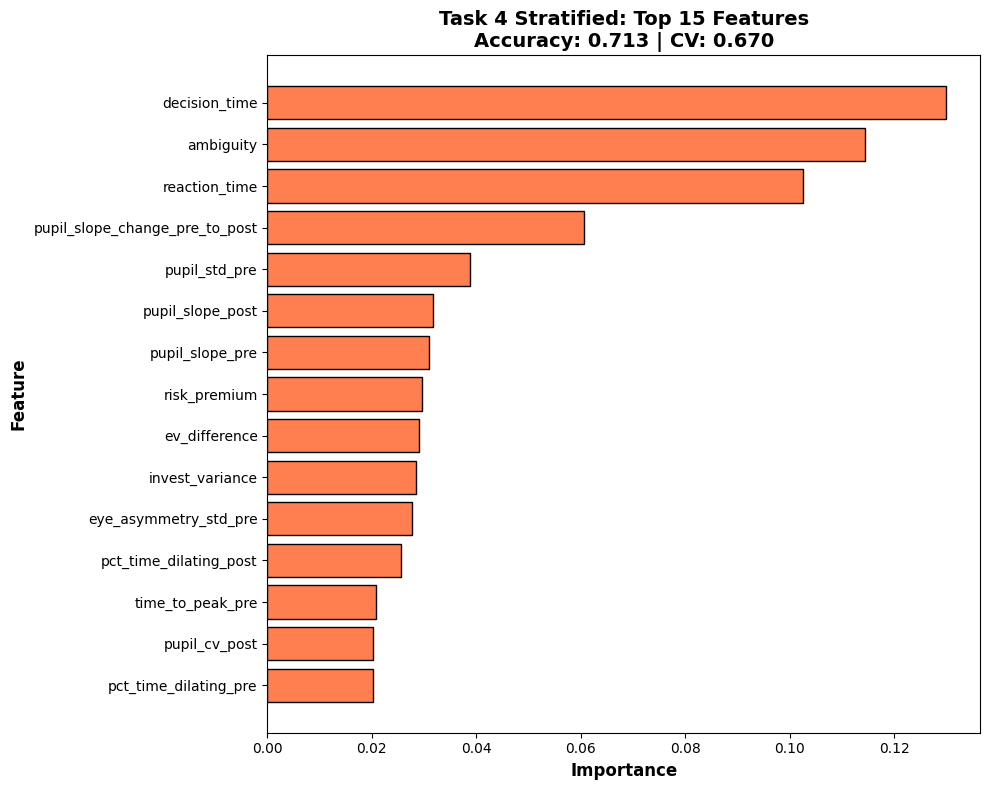

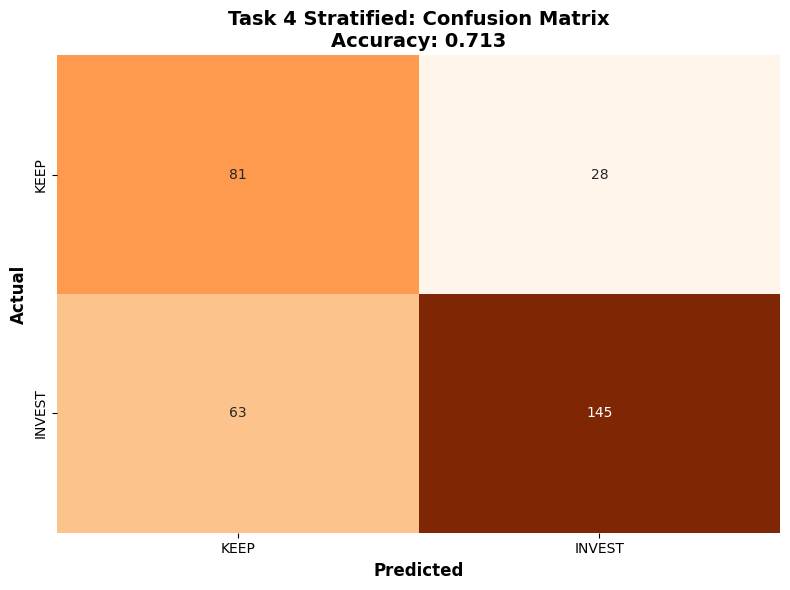

In [109]:
# =============================================================================
# TASK 4: BEHAVIOR + PHYSIOLOGY → OUTCOME - STRATIFIED SPLIT
# =============================================================================

print(f"\n{'='*80}")
print(f"TASK 4: BEHAVIOR + PHYSIOLOGY → OUTCOME - STRATIFIED")
print(f"{'='*80}")

# Use the same train/test indices from before
print(f"Train samples: {len(train_indices)}")
print(f"Test samples: {len(test_indices)}")

# Prepare combined data
X_combined_array = X_combined.values
y = outcomes

# Split data
X_train_strat = X_combined_array[train_indices]
X_test_strat = X_combined_array[test_indices]
y_train_strat = y[train_indices]
y_test_strat = y[test_indices]

print(f"\nTrain distribution: KEEP={np.sum(y_train_strat==0)}, INVEST={np.sum(y_train_strat==1)}")
print(f"Test distribution: KEEP={np.sum(y_test_strat==0)}, INVEST={np.sum(y_test_strat==1)}")

# Train model
rf_strat_task4 = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced'
)

rf_strat_task4.fit(X_train_strat, y_train_strat)

# Predictions
y_pred_strat_task4 = rf_strat_task4.predict(X_test_strat)

# Evaluation
print(f"\n{'='*80}")
print(f"TASK 4 STRATIFIED RESULTS")
print(f"{'='*80}")
print("\nClassification Report:")
print(classification_report(y_test_strat, y_pred_strat_task4, target_names=['KEEP', 'INVEST']))

accuracy_strat_task4 = accuracy_score(y_test_strat, y_pred_strat_task4)
f1_strat_task4 = f1_score(y_test_strat, y_pred_strat_task4, average='weighted')
print(f"\nAccuracy: {accuracy_strat_task4:.3f}")
print(f"F1 Score: {f1_strat_task4:.3f}")

# Cross-validation
cv_scores_strat_task4 = cross_val_score(rf_strat_task4, X_combined_array, y, cv=5, scoring='accuracy')
print(f"\nCross-validation scores: {cv_scores_strat_task4}")
print(f"Mean CV Accuracy: {cv_scores_strat_task4.mean():.3f} (+/- {cv_scores_strat_task4.std():.3f})")

# Feature importance
feature_importance_strat_task4 = pd.DataFrame({
    'feature': X_combined.columns,
    'importance': rf_strat_task4.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 15 Important Features:")
print(feature_importance_strat_task4.head(15).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(10, 8))
plt.barh(range(15), feature_importance_strat_task4['importance'].head(15)[::-1], color='coral', edgecolor='black')
plt.yticks(range(15), feature_importance_strat_task4['feature'].head(15)[::-1])
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title(f'Task 4 Stratified: Top 15 Features\nAccuracy: {accuracy_strat_task4:.3f} | CV: {cv_scores_strat_task4.mean():.3f}', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Confusion matrix
cm_strat_task4 = confusion_matrix(y_test_strat, y_pred_strat_task4)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_strat_task4, annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=['KEEP', 'INVEST'], yticklabels=['KEEP', 'INVEST'], ax=ax)
ax.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax.set_title(f'Task 4 Stratified: Confusion Matrix\nAccuracy: {accuracy_strat_task4:.3f}', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


### Pre predict post


TASK 4: BEHAVIOR + PHYSIOLOGY → OUTCOME - STRATIFIED (PRE)

Total subjects: 10
Train samples: 727
Test samples: 317

Train distribution: KEEP=247, INVEST=480
Test distribution: KEEP=109, INVEST=208

TASK 4 STRATIFIED (PRE) RESULTS

Classification Report:
              precision    recall  f1-score   support

        KEEP       0.57      0.76      0.65       109
      INVEST       0.85      0.70      0.77       208

    accuracy                           0.72       317
   macro avg       0.71      0.73      0.71       317
weighted avg       0.75      0.72      0.73       317


Accuracy: 0.722
F1 Score: 0.729

Cross-validation scores: [0.6076555  0.72248804 0.65550239 0.6076555  0.67788462]
Mean CV Accuracy: 0.654 (+/- 0.044)

Top 15 Important Features:
                       feature  importance
                 decision_time    0.143023
                 reaction_time    0.118200
                     ambiguity    0.108784
pupil_slope_change_pre_to_post    0.071448
               pupil_s

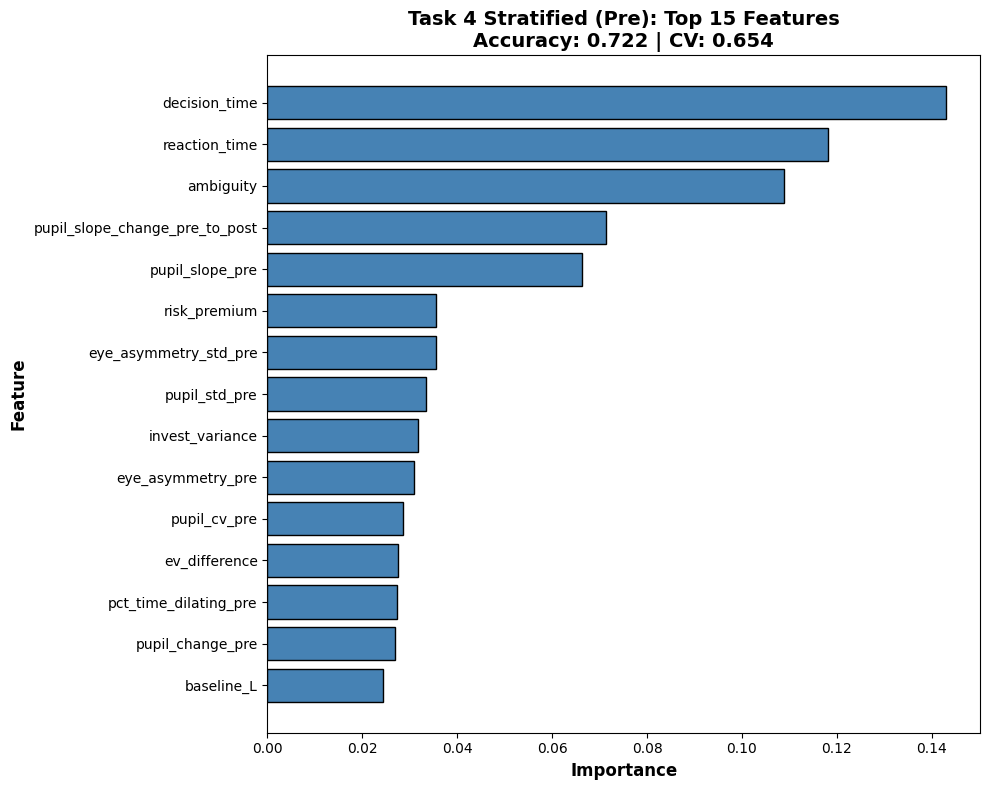

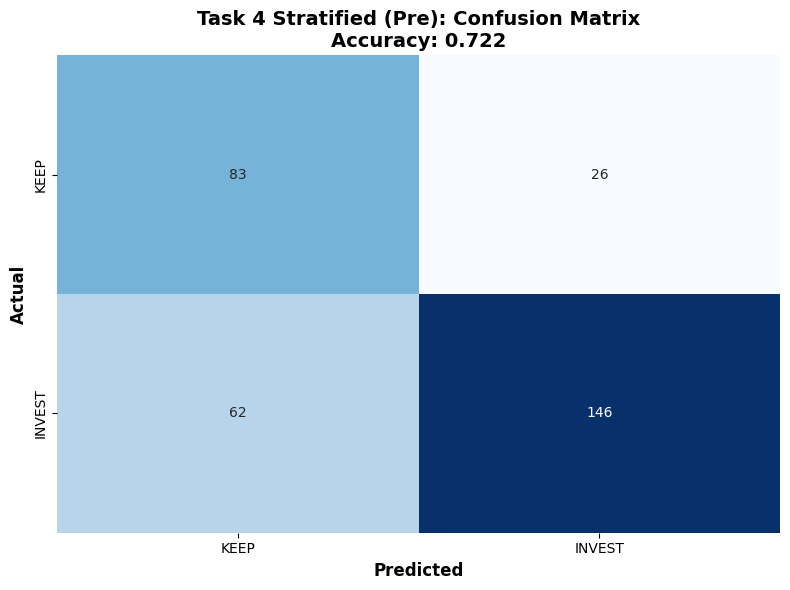

In [110]:
# =============================================================================
# TASK 4: BEHAVIOR + PHYSIOLOGY → OUTCOME - STRATIFIED SPLIT (Pre)
# =============================================================================

print(f"\n{'='*80}")
print(f"TASK 4: BEHAVIOR + PHYSIOLOGY → OUTCOME - STRATIFIED (PRE)")
print(f"{'='*80}")

# Get unique subjects
unique_subjects = physiology_df['subject_id'].unique()
print(f"\nTotal subjects: {len(unique_subjects)}")

# For each subject, take 70% for train, 30% for test
train_indices = []
test_indices = []

for subject in unique_subjects:
    subject_mask = physiology_df['subject_id'] == subject
    subject_indices = np.where(subject_mask)[0]
    
    # Get subject's outcomes
    subject_outcomes = outcomes[subject_indices]
    
    # Stratified split for this subject
    if len(subject_indices) > 1:
        train_idx, test_idx = train_test_split(
            subject_indices, 
            test_size=0.3, 
            random_state=42,
            stratify=subject_outcomes if len(np.unique(subject_outcomes)) > 1 else None
        )
    else:
        # If only one sample, put in train
        train_idx = subject_indices
        test_idx = []
    
    train_indices.extend(train_idx)
    test_indices.extend(test_idx)

train_indices = np.array(train_indices)
test_indices = np.array(test_indices)

print(f"Train samples: {len(train_indices)}")
print(f"Test samples: {len(test_indices)}")

# Prepare combined data
X_combined_pre_array = X_combined_pre.values
y = outcomes

# Split data
X_train_strat = X_combined_pre_array[train_indices]
X_test_strat = X_combined_pre_array[test_indices]
y_train_strat = y[train_indices]
y_test_strat = y[test_indices]

print(f"\nTrain distribution: KEEP={np.sum(y_train_strat==0)}, INVEST={np.sum(y_train_strat==1)}")
print(f"Test distribution: KEEP={np.sum(y_test_strat==0)}, INVEST={np.sum(y_test_strat==1)}")

# Train model
rf_strat_task4_pre = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced'
)

rf_strat_task4_pre.fit(X_train_strat, y_train_strat)

# Predictions
y_pred_strat_task4_pre = rf_strat_task4_pre.predict(X_test_strat)

# Evaluation
print(f"\n{'='*80}")
print(f"TASK 4 STRATIFIED (PRE) RESULTS")
print(f"{'='*80}")
print("\nClassification Report:")
print(classification_report(y_test_strat, y_pred_strat_task4_pre, target_names=['KEEP', 'INVEST']))

accuracy_strat_task4_pre = accuracy_score(y_test_strat, y_pred_strat_task4_pre)
f1_strat_task4_pre = f1_score(y_test_strat, y_pred_strat_task4_pre, average='weighted')
print(f"\nAccuracy: {accuracy_strat_task4_pre:.3f}")
print(f"F1 Score: {f1_strat_task4_pre:.3f}")

# Cross-validation
cv_scores_strat_task4_pre = cross_val_score(rf_strat_task4_pre, X_combined_pre_array, y, cv=5, scoring='accuracy')
print(f"\nCross-validation scores: {cv_scores_strat_task4_pre}")
print(f"Mean CV Accuracy: {cv_scores_strat_task4_pre.mean():.3f} (+/- {cv_scores_strat_task4_pre.std():.3f})")

# Feature importance
feature_importance_strat_task4_pre = pd.DataFrame({
    'feature': X_combined_pre.columns,
    'importance': rf_strat_task4_pre.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 15 Important Features:")
print(feature_importance_strat_task4_pre.head(15).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(10, 8))
plt.barh(range(15), feature_importance_strat_task4_pre['importance'].head(15)[::-1], color='steelblue', edgecolor='black')
plt.yticks(range(15), feature_importance_strat_task4_pre['feature'].head(15)[::-1])
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title(f'Task 4 Stratified (Pre): Top 15 Features\nAccuracy: {accuracy_strat_task4_pre:.3f} | CV: {cv_scores_strat_task4_pre.mean():.3f}', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Confusion matrix
cm_strat_task4_pre = confusion_matrix(y_test_strat, y_pred_strat_task4_pre)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_strat_task4_pre, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['KEEP', 'INVEST'], yticklabels=['KEEP', 'INVEST'], ax=ax)
ax.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax.set_title(f'Task 4 Stratified (Pre): Confusion Matrix\nAccuracy: {accuracy_strat_task4_pre:.3f}', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


### Post predict post


TASK 4: BEHAVIOR + PHYSIOLOGY → OUTCOME - STRATIFIED (POST)
Train samples: 727
Test samples: 317

Train distribution: KEEP=247, INVEST=480
Test distribution: KEEP=109, INVEST=208

TASK 4 STRATIFIED (POST) RESULTS

Classification Report:
              precision    recall  f1-score   support

        KEEP       0.56      0.70      0.62       109
      INVEST       0.82      0.71      0.76       208

    accuracy                           0.71       317
   macro avg       0.69      0.70      0.69       317
weighted avg       0.73      0.71      0.71       317


Accuracy: 0.707
F1 Score: 0.713

Cross-validation scores: [0.64114833 0.75598086 0.70813397 0.6507177  0.71153846]
Mean CV Accuracy: 0.694 (+/- 0.042)

Top 15 Important Features:
                       feature  importance
                 reaction_time    0.143607
                     ambiguity    0.135808
                 decision_time    0.134975
pupil_slope_change_pre_to_post    0.094523
              pupil_slope_post    0.0572

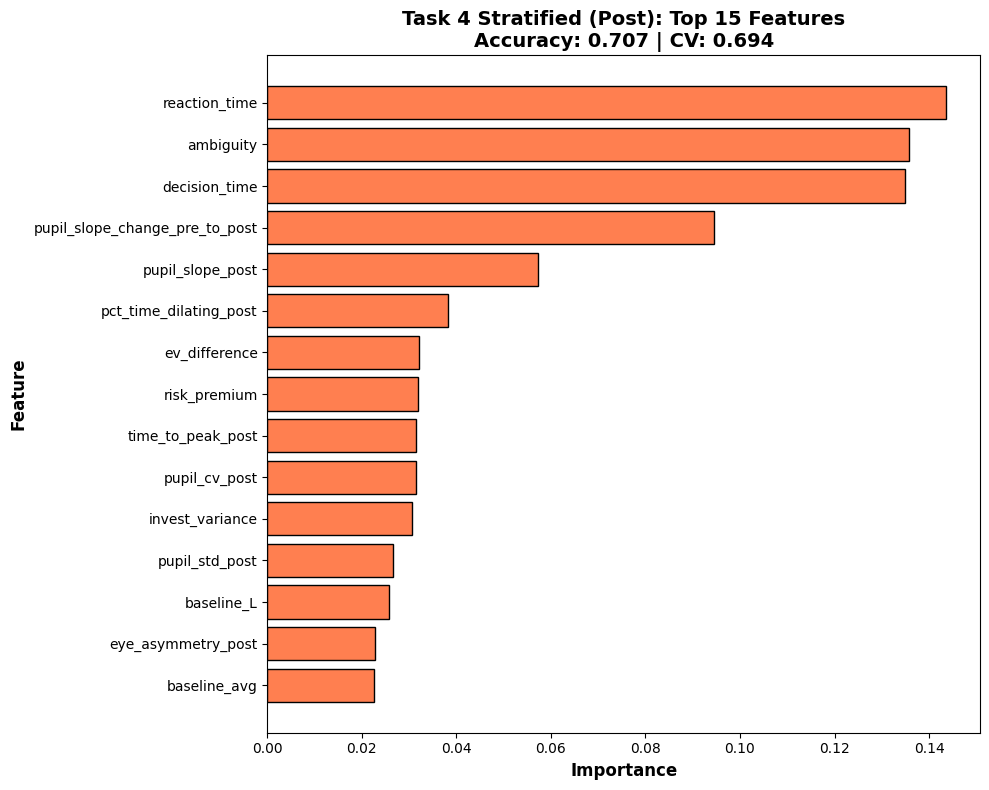

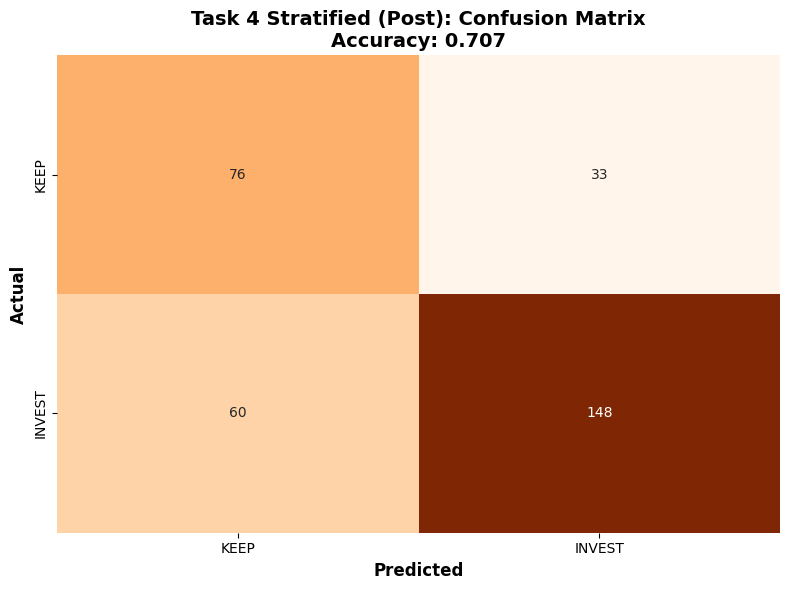

In [111]:
# =============================================================================
# TASK 4: BEHAVIOR + PHYSIOLOGY → OUTCOME - STRATIFIED SPLIT (Post)
# =============================================================================

print(f"\n{'='*80}")
print(f"TASK 4: BEHAVIOR + PHYSIOLOGY → OUTCOME - STRATIFIED (POST)")
print(f"{'='*80}")

# Use the same train/test indices from before
print(f"Train samples: {len(train_indices)}")
print(f"Test samples: {len(test_indices)}")

# Prepare combined data
X_combined_post_array = X_combined_post.values
y = outcomes

# Split data
X_train_strat = X_combined_post_array[train_indices]
X_test_strat = X_combined_post_array[test_indices]
y_train_strat = y[train_indices]
y_test_strat = y[test_indices]

print(f"\nTrain distribution: KEEP={np.sum(y_train_strat==0)}, INVEST={np.sum(y_train_strat==1)}")
print(f"Test distribution: KEEP={np.sum(y_test_strat==0)}, INVEST={np.sum(y_test_strat==1)}")

# Train model
rf_strat_task4_post = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced'
)

rf_strat_task4_post.fit(X_train_strat, y_train_strat)

# Predictions
y_pred_strat_task4_post = rf_strat_task4_post.predict(X_test_strat)

# Evaluation
print(f"\n{'='*80}")
print(f"TASK 4 STRATIFIED (POST) RESULTS")
print(f"{'='*80}")
print("\nClassification Report:")
print(classification_report(y_test_strat, y_pred_strat_task4_post, target_names=['KEEP', 'INVEST']))

accuracy_strat_task4_post = accuracy_score(y_test_strat, y_pred_strat_task4_post)
f1_strat_task4_post = f1_score(y_test_strat, y_pred_strat_task4_post, average='weighted')
print(f"\nAccuracy: {accuracy_strat_task4_post:.3f}")
print(f"F1 Score: {f1_strat_task4_post:.3f}")

# Cross-validation
cv_scores_strat_task4_post = cross_val_score(rf_strat_task4_post, X_combined_post_array, y, cv=5, scoring='accuracy')
print(f"\nCross-validation scores: {cv_scores_strat_task4_post}")
print(f"Mean CV Accuracy: {cv_scores_strat_task4_post.mean():.3f} (+/- {cv_scores_strat_task4_post.std():.3f})")

# Feature importance
feature_importance_strat_task4_post = pd.DataFrame({
    'feature': X_combined_post.columns,
    'importance': rf_strat_task4_post.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 15 Important Features:")
print(feature_importance_strat_task4_post.head(15).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(10, 8))
plt.barh(range(15), feature_importance_strat_task4_post['importance'].head(15)[::-1], color='coral', edgecolor='black')
plt.yticks(range(15), feature_importance_strat_task4_post['feature'].head(15)[::-1])
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title(f'Task 4 Stratified (Post): Top 15 Features\nAccuracy: {accuracy_strat_task4_post:.3f} | CV: {cv_scores_strat_task4_post.mean():.3f}', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Confusion matrix
cm_strat_task4_post = confusion_matrix(y_test_strat, y_pred_strat_task4_post)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_strat_task4_post, annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=['KEEP', 'INVEST'], yticklabels=['KEEP', 'INVEST'], ax=ax)
ax.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax.set_title(f'Task 4 Stratified (Post): Confusion Matrix\nAccuracy: {accuracy_strat_task4_post:.3f}', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## Comparison


TASK 4: BEHAVIOR + PHYSIOLOGY → OUTCOME - ALL METHODS COMPARISON


TASK 4 RESULTS COMPARISON:
          Method Features  Accuracy  F1_Score
    Random Split      Pre  0.710191  0.715397
    Random Split     Post  0.678344  0.685423
            LOSO      Pre  0.670423  0.681016
            LOSO     Post  0.680825  0.700912
Stratified Split      Pre  0.722397  0.728921
Stratified Split     Post  0.706625  0.712609


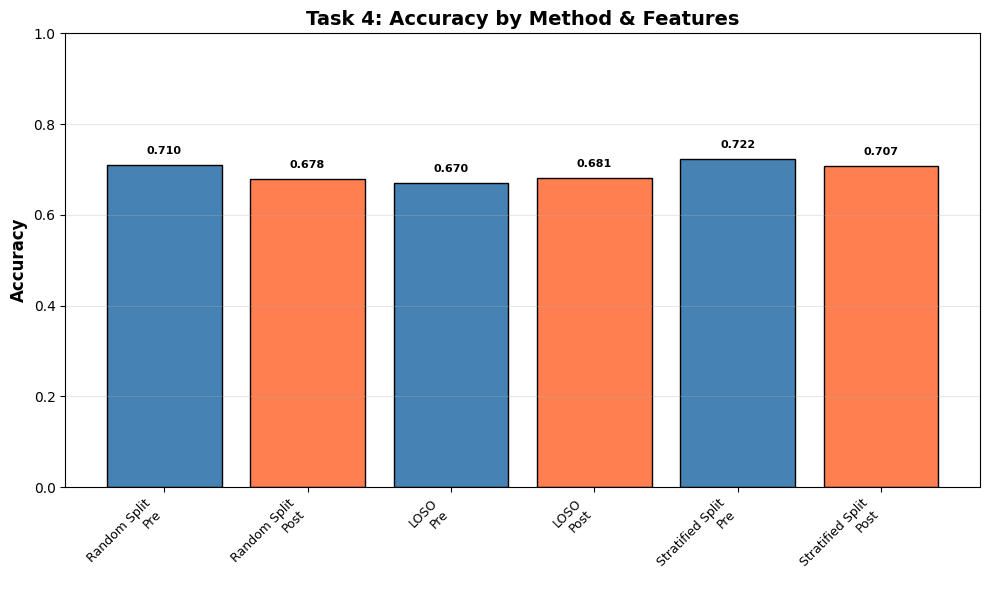


KEY FINDINGS:
Best performing method: Stratified Split with Pre features
Accuracy: 0.722

Pre vs Post features comparison:
  Average Accuracy (Pre): 0.701
  Average Accuracy (Post): 0.689


In [112]:
# =============================================================================
# TASK 4 RESULTS SUMMARY - ALL METHODS COMPARISON
# =============================================================================

print(f"\n{'='*80}")
print(f"TASK 4: BEHAVIOR + PHYSIOLOGY → OUTCOME - ALL METHODS COMPARISON")
print(f"{'='*80}\n")

# Collect all Task 4 results
task4_results = []

# Random Split - Pre
task4_results.append({
    'Method': 'Random Split',
    'Features': 'Pre',
    'Accuracy': accuracy_combined_pre,
    'F1_Score': f1_combined_pre
})

# Random Split - Post
task4_results.append({
    'Method': 'Random Split',
    'Features': 'Post',
    'Accuracy': accuracy_combined_post,
    'F1_Score': f1_combined_post
})

# LOSO - Pre
task4_results.append({
    'Method': 'LOSO',
    'Features': 'Pre',
    'Accuracy': loso_df_task4_pre['accuracy'].mean(),
    'F1_Score': loso_df_task4_pre['f1_score'].mean()
})

# LOSO - Post
task4_results.append({
    'Method': 'LOSO',
    'Features': 'Post',
    'Accuracy': loso_df_task4_post['accuracy'].mean(),
    'F1_Score': loso_df_task4_post['f1_score'].mean()
})

# Stratified - Pre
task4_results.append({
    'Method': 'Stratified Split',
    'Features': 'Pre',
    'Accuracy': accuracy_strat_task4_pre,
    'F1_Score': f1_strat_task4_pre
})

# Stratified - Post
task4_results.append({
    'Method': 'Stratified Split',
    'Features': 'Post',
    'Accuracy': accuracy_strat_task4_post,
    'F1_Score': f1_strat_task4_post
})

# Create DataFrame
task4_comparison_df = pd.DataFrame(task4_results)

print("\nTASK 4 RESULTS COMPARISON:")
print(task4_comparison_df.to_string(index=False))

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Accuracy comparison
x_pos = np.arange(len(task4_comparison_df))
colors = ['steelblue' if feat == 'Pre' else 'coral' for feat in task4_comparison_df['Features']]
ax.bar(x_pos, task4_comparison_df['Accuracy'], color=colors, edgecolor='black')
ax.set_xticks(x_pos)
ax.set_xticklabels([f"{row['Method']}\n{row['Features']}" for _, row in task4_comparison_df.iterrows()], 
                     rotation=45, ha='right', fontsize=9)
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Task 4: Accuracy by Method & Features', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(task4_comparison_df['Accuracy']):
    ax.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# F1 Score comparison
ax2.bar(x_pos, task4_comparison_df['F1_Score'], color=colors, edgecolor='black')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f"{row['Method']}\n{row['Features']}" for _, row in task4_comparison_df.iterrows()], 
                     rotation=45, ha='right', fontsize=9)
ax2.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
ax2.set_title('Task 4: F1 Score by Method & Features', fontsize=14, fontweight='bold')
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(task4_comparison_df['F1_Score']):
    ax2.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("KEY FINDINGS:")
print("="*80)
best_idx = task4_comparison_df['Accuracy'].idxmax()
best_method = task4_comparison_df.loc[best_idx, 'Method']
best_features = task4_comparison_df.loc[best_idx, 'Features']
best_accuracy = task4_comparison_df.loc[best_idx, 'Accuracy']
print(f"Best performing method: {best_method} with {best_features} features")
print(f"Accuracy: {best_accuracy:.3f}")

# Compare Pre vs Post
print(f"\nPre vs Post features comparison:")
pre_mean = task4_comparison_df[task4_comparison_df['Features'] == 'Pre']['Accuracy'].mean()
post_mean = task4_comparison_df[task4_comparison_df['Features'] == 'Post']['Accuracy'].mean()
print(f"  Average Accuracy (Pre): {pre_mean:.3f}")
print(f"  Average Accuracy (Post): {post_mean:.3f}")
